# Normalizing flows:  re-implementation of the Glow paper

* train model on CelebaA dataset
* images are resized to 64x64, this still fits into memory

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import numpy as np
import tensorflow as tf
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import utils
import nets
import flow_layers as fl

In [4]:
tf.set_random_seed(0)
sess = tf.InteractiveSession()

## Import dataset

In [5]:
batch_size = 8
image_size = 64
x_train_samples = utils.create_tfrecord_dataset_iterator(
    "datasets/celeba/celeba_train.tfrecords", batch_size=batch_size, image_size=image_size
)
x_valid_samples = utils.create_tfrecord_dataset_iterator(
    "datasets/celeba/celeba_valid.tfrecords", batch_size=batch_size, image_size=image_size
)

x_train_samples

<tf.Tensor 'truediv:0' shape=(8, 64, 64, 3) dtype=float32>

### Check shapes (initial call will take a while)

In [6]:
x_valid_samples.eval().shape

(8, 64, 64, 3)

In [7]:
x_exampled = x_valid_samples.eval()

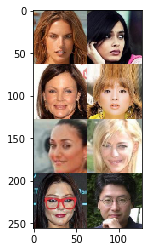

In [8]:
plt.imshow(utils.plot_grid(x_valid_samples).eval())

In [10]:
%timeit -n 100 x_valid_samples.eval()

907 µs ± 57.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Build Flow with Resnet blocks 

In [9]:
nn_template_fn = nets.OpenAITemplate(
    width=128  # one can try to make it bigger
)

In [10]:
layers, actnorm_layers = nets.create_simple_flow(
    num_steps=22, 
    num_scales=4, 
    template_fn=nn_template_fn
)

# create model
images = x_train_samples
flow = fl.InputLayer(images)
model_flow = fl.ChainLayer(layers)
output_flow = model_flow(flow, forward=True)

QuantizeImage/Forward/                  : x=[8, 64, 64, 3]	z=[None]	logdet=[8]
SqueezingLayer/Forward/Scale1           : x=[8, 32, 32, 12]	z=[None]	logdet=[8]
ActnormBiasLayer/Forward/               : x=[8, 32, 32, 12]	z=[None]	logdet=[8]
ActnormScaleLayer/Forward/              : x=[8, 32, 32, 12]	z=[None]	logdet=[8]
ChainLayer/Forward/                     : x=[8, 32, 32, 12]	z=[None]	logdet=[8]
ActnormLayer/Forward/                   : x=[8, 32, 32, 12]	z=[None]	logdet=[8]
InvertibleConv1x1Layer/Forward/         : x=[8, 32, 32, 12]	z=[None]	logdet=[8]
AffineCouplingLayer/Forward/            : x=[8, 32, 32, 12]	z=[None]	logdet=[8]
ChainLayer/Forward/Step1                : x=[8, 32, 32, 12]	z=[None]	logdet=[8]
ActnormBiasLayer/Forward/               : x=[8, 32, 32, 12]	z=[None]	logdet=[8]
ActnormScaleLayer/Forward/              : x=[8, 32, 32, 12]	z=[None]	logdet=[8]
ChainLayer/Forward/                     : x=[8, 32, 32, 12]	z=[None]	logdet=[8]
ActnormLayer/Forward/                   :

## Prepare output tensors

In [11]:
y, logdet, z = output_flow
output_flow

(<tf.Tensor 'ChainLayer/outputs/x:0' shape=(8, 4, 4, 48) dtype=float32>,
 <tf.Tensor 'ChainLayer/outputs/lodget:0' shape=(8,) dtype=float32>,
 <tf.Tensor 'ChainLayer/outputs/z:0' shape=(8, 4, 4, 720) dtype=float32>)

## Build loss function

* Here simply the $-logp(x)$

In [12]:
tfd = tf.contrib.distributions

beta_ph = tf.placeholder(tf.float32, [])

y_flatten = tf.reshape(y, [batch_size, -1])
z_flatten = tf.reshape(z, [batch_size, -1])

prior_y = tfd.MultivariateNormalDiag(loc=tf.zeros_like(y_flatten), scale_diag=beta_ph * tf.ones_like(y_flatten))
prior_z = tfd.MultivariateNormalDiag(loc=tf.zeros_like(z_flatten), scale_diag=beta_ph * tf.ones_like(z_flatten))

log_prob_y =  prior_y.log_prob(y_flatten)
log_prob_z =  prior_z.log_prob(z_flatten)

In [13]:
prior_z

<tf.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=(8,) event_shape=(11520,) dtype=float32>

### The MLE loss

In [14]:
loss = log_prob_y + log_prob_z + logdet
loss = - tf.reduce_mean(loss)

### The L2 regularization loss 

In [15]:
trainable_variables = tf.trainable_variables() 
l2_reg = 0.00001 
l2_loss = l2_reg * tf.add_n([ tf.nn.l2_loss(v) for v in trainable_variables])

### Debug model, print variables 

In [16]:
total_params = 0
for k, v in enumerate(trainable_variables):
    num_params = np.prod(v.shape.as_list())
    total_params += num_params
#     print(f"[{k:4}][{num_params:6}] {v.op.name[:96]}")

print(f"total_params: {total_params/1e6} M")

total_params: 9.025104 M


### Total loss -logp(x) + l2_loss

In [17]:
sess.run(tf.global_variables_initializer())

In [18]:
loss_per_pixel = loss / image_size / image_size  

In [19]:
total_loss = l2_loss + loss_per_pixel 

In [20]:
l2_loss.eval(feed_dict={beta_ph: 1.0}), loss_per_pixel.eval(feed_dict={beta_ph: 1.0})

(0.33366358, 2.8831034)

## Create backward flow to generate samples

In [21]:
sample_y_flatten = prior_y.sample()
sample_y = tf.reshape(sample_y_flatten, y.shape.as_list())
sample_z = tf.reshape(prior_z.sample(), z.shape.as_list())
sampled_logdet = prior_y.log_prob(sample_y_flatten)

In [22]:
inverse_flow = sample_y, sampled_logdet, sample_z
sampled_flow = model_flow(inverse_flow, forward=False)

FactorOutLayer/Backward/Scale4          : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
AffineCouplingLayer/Backward/           : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
InvertibleConv1x1Layer/Backward/        : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
ActnormScaleLayer/Backward/             : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
ActnormBiasLayer/Backward/              : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
ChainLayer/Backward/                    : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
ActnormLayer/Backward/                  : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
ChainLayer/Backward/Step22              : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
AffineCouplingLayer/Backward/           : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
InvertibleConv1x1Layer/Backward/        : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
ActnormScaleLayer/Backward/             : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
ActnormBiasLayer/Backward/              : y=[8, 4, 4, 

In [23]:
total_params = 0
for k, v in enumerate(trainable_variables):
    num_params = np.prod(v.shape.as_list())
    total_params += num_params
print(f"total_params: {total_params/1e6} M")

total_params: 9.025104 M


In [24]:
x_flow_sampled, _, _ = sampled_flow

In [25]:
x_flow_sampled.eval({beta_ph: 1.0}).shape

(8, 64, 64, 3)

## Define optimizer and learning rate

In [26]:
lr_ph = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(lr_ph)
train_op = optimizer.minimize(total_loss)

## Initialize Actnorms using DDI

In [27]:
sess.run(tf.global_variables_initializer())
nets.initialize_actnorms(
    sess,
    feed_dict_fn=lambda: {beta_ph: 1.0},
    actnorm_layers=actnorm_layers,
    num_steps=10,
)

100%|██████████| 88/88 [04:39<00:00,  3.17s/it]


## Train model, define metrics and trainer

In [28]:
metrics = utils.Metrics(50, metrics_tensors={"total_loss": total_loss, "loss_per_pixel": loss_per_pixel, "l2_loss": l2_loss})
plot_metrics_hook = utils.PlotMetricsHook(metrics, step=1000)

In [29]:
sess.run(train_op, feed_dict={lr_ph: 0.0, beta_ph: 1.0})

In [30]:
total_loss.eval(feed_dict={lr_ph: 0.0, beta_ph: 1.0})

-3.692878

### Initial samples from model

In [31]:
quantize_image_layer = layers[0]
aux_feed_dict = {lr_ph: 0.0, beta_ph: 1.0}

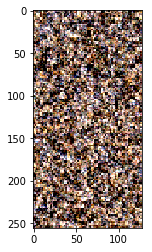

In [32]:
x_flow_sampled_uint = quantize_image_layer.to_uint8(x_flow_sampled)
plt.imshow(utils.plot_grid(x_flow_sampled_uint).eval(aux_feed_dict))

### Train model

* We start from small learning rate (warm-up)

In [33]:
utils.trainer(
    sess, 
    num_steps=100, 
    train_op=train_op, 
    feed_dict_fn=lambda: {lr_ph: 0.0001, beta_ph: 1.0}, 
    metrics=[metrics], 
    hooks=[plot_metrics_hook]
)

 50%|█████     | 50/100 [00:25<00:25,  1.97it/s]

total_loss -5.8306065
loss_per_pixel -6.1635704
l2_loss 0.33296412


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]

total_loss -6.0327253
loss_per_pixel -6.364601
l2_loss 0.33187565


  5%|▌         | 50/1000 [00:12<03:59,  3.97it/s]

total_loss -5.7937775
loss_per_pixel -6.1221514
l2_loss 0.3283737


 10%|█         | 100/1000 [00:25<03:46,  3.98it/s]

total_loss -6.178633
loss_per_pixel -6.503704
l2_loss 0.32507098


 15%|█▌        | 150/1000 [00:37<03:34,  3.96it/s]

total_loss -6.347782
loss_per_pixel -6.6698837
l2_loss 0.32210174


 20%|██        | 200/1000 [00:50<03:23,  3.94it/s]

total_loss -6.039619
loss_per_pixel -6.3591127
l2_loss 0.31949386


 25%|██▌       | 250/1000 [01:03<03:09,  3.95it/s]

total_loss -6.2724447
loss_per_pixel -6.589654
l2_loss 0.31720936


 30%|███       | 300/1000 [01:16<02:58,  3.92it/s]

total_loss -6.3311143
loss_per_pixel -6.6462727
l2_loss 0.31515843


 35%|███▌      | 350/1000 [01:29<02:45,  3.92it/s]

total_loss -6.371146
loss_per_pixel -6.6844645
l2_loss 0.3133181


 40%|████      | 400/1000 [01:42<02:33,  3.90it/s]

total_loss -6.592354
loss_per_pixel -6.903989
l2_loss 0.31163484


 45%|████▌     | 450/1000 [01:55<02:21,  3.89it/s]

total_loss -6.356493
loss_per_pixel -6.6665707
l2_loss 0.31007776


 50%|█████     | 500/1000 [02:08<02:08,  3.88it/s]

total_loss -6.509566
loss_per_pixel -6.8181977
l2_loss 0.30863202


 55%|█████▌    | 550/1000 [02:21<01:56,  3.88it/s]

total_loss -6.353439
loss_per_pixel -6.660705
l2_loss 0.30726644


 60%|██████    | 600/1000 [02:34<01:42,  3.88it/s]

total_loss -6.6977453
loss_per_pixel -7.003741
l2_loss 0.30599555


 65%|██████▌   | 650/1000 [02:47<01:30,  3.89it/s]

total_loss -6.4075956
loss_per_pixel -6.712385
l2_loss 0.30478963


 70%|███████   | 700/1000 [03:00<01:17,  3.88it/s]

total_loss -6.405367
loss_per_pixel -6.7090263
l2_loss 0.30365965


 75%|███████▌  | 750/1000 [03:13<01:04,  3.88it/s]

total_loss -6.4655747
loss_per_pixel -6.768167
l2_loss 0.30259228


 80%|████████  | 800/1000 [03:25<00:51,  3.89it/s]

total_loss -6.4094596
loss_per_pixel -6.7110467
l2_loss 0.3015869


 85%|████████▌ | 850/1000 [03:38<00:38,  3.89it/s]

total_loss -6.6467657
loss_per_pixel -6.947389
l2_loss 0.30062354


 90%|█████████ | 900/1000 [03:51<00:25,  3.89it/s]

total_loss -6.7351065
loss_per_pixel -7.0348034
l2_loss 0.29969686


 95%|█████████▌| 950/1000 [04:03<00:12,  3.90it/s]

total_loss -6.670278
loss_per_pixel -6.969098
l2_loss 0.2988198


100%|█████████▉| 999/1000 [04:16<00:00,  3.90it/s]

total_loss -6.615972
loss_per_pixel -6.9139643
l2_loss 0.2979923


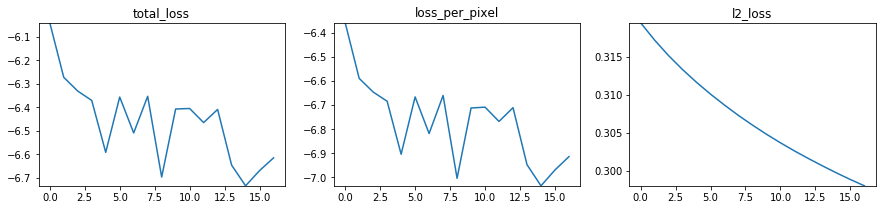

100%|██████████| 1000/1000 [04:16<00:00,  3.89it/s]


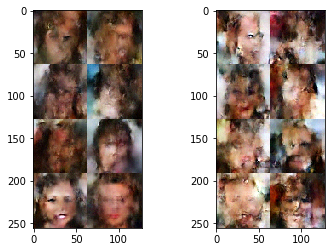

  5%|▌         | 50/1000 [00:13<04:07,  3.84it/s]

total_loss -6.597483
loss_per_pixel -6.894679
l2_loss 0.297196


 10%|█         | 100/1000 [00:25<03:51,  3.89it/s]

total_loss -6.652015
loss_per_pixel -6.9484463
l2_loss 0.29643115


 15%|█▌        | 150/1000 [00:38<03:40,  3.86it/s]

total_loss -6.6243277
loss_per_pixel -6.9200363
l2_loss 0.29570854


 20%|██        | 200/1000 [00:51<03:26,  3.87it/s]

total_loss -6.727473
loss_per_pixel -7.0224752
l2_loss 0.29500243


 25%|██▌       | 250/1000 [01:04<03:13,  3.88it/s]

total_loss -6.639059
loss_per_pixel -6.9333925
l2_loss 0.2943334


 30%|███       | 300/1000 [01:17<03:01,  3.85it/s]

total_loss -6.4870214
loss_per_pixel -6.7807293
l2_loss 0.29370776


 35%|███▌      | 350/1000 [01:30<02:48,  3.85it/s]

total_loss -6.531388
loss_per_pixel -6.824496
l2_loss 0.29310814


 40%|████      | 400/1000 [01:43<02:35,  3.87it/s]

total_loss -6.7191114
loss_per_pixel -7.0116305
l2_loss 0.2925191


 45%|████▌     | 450/1000 [01:55<02:21,  3.88it/s]

total_loss -6.5710726
loss_per_pixel -6.863043
l2_loss 0.29197007


 50%|█████     | 500/1000 [02:08<02:08,  3.88it/s]

total_loss -6.830239
loss_per_pixel -7.1216755
l2_loss 0.29143652


 55%|█████▌    | 550/1000 [02:21<01:56,  3.88it/s]

total_loss -6.53629
loss_per_pixel -6.827227
l2_loss 0.29093677


 60%|██████    | 600/1000 [02:34<01:43,  3.88it/s]

total_loss -6.5513115
loss_per_pixel -6.841742
l2_loss 0.29043075


 65%|██████▌   | 650/1000 [02:47<01:30,  3.87it/s]

total_loss -6.607665
loss_per_pixel -6.897612
l2_loss 0.28994688


 70%|███████   | 700/1000 [03:00<01:17,  3.89it/s]

total_loss -6.7105546
loss_per_pixel -7.0000486
l2_loss 0.28949407


 75%|███████▌  | 750/1000 [03:12<01:04,  3.90it/s]

total_loss -6.6148863
loss_per_pixel -6.9039507
l2_loss 0.28906438


 80%|████████  | 800/1000 [03:25<00:51,  3.90it/s]

total_loss -6.890155
loss_per_pixel -7.178811
l2_loss 0.28865606


 85%|████████▌ | 850/1000 [03:37<00:38,  3.90it/s]

total_loss -6.69595
loss_per_pixel -6.9841976
l2_loss 0.28824762


 90%|█████████ | 900/1000 [03:50<00:25,  3.90it/s]

total_loss -6.853452
loss_per_pixel -7.141311
l2_loss 0.28785896


 95%|█████████▌| 950/1000 [04:03<00:12,  3.90it/s]

total_loss -6.433374
loss_per_pixel -6.720848
l2_loss 0.28747398


100%|█████████▉| 999/1000 [04:15<00:00,  3.91it/s]

total_loss -6.904163
loss_per_pixel -7.191267
l2_loss 0.2871041


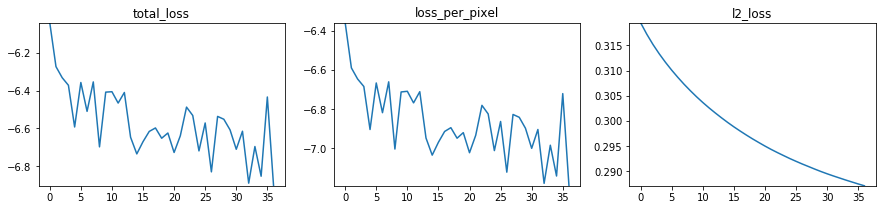

100%|██████████| 1000/1000 [04:16<00:00,  3.90it/s]


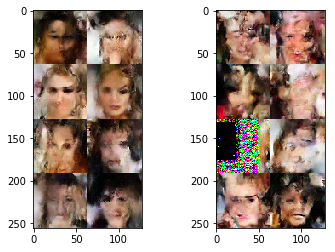

  5%|▌         | 50/1000 [00:12<04:04,  3.89it/s]

total_loss -6.69233
loss_per_pixel -6.9791126
l2_loss 0.2867828


 10%|█         | 100/1000 [00:25<03:51,  3.88it/s]

total_loss -6.6275663
loss_per_pixel -6.91405
l2_loss 0.28648385


 15%|█▌        | 150/1000 [00:38<03:37,  3.92it/s]

total_loss -6.562383
loss_per_pixel -6.8485374
l2_loss 0.28615436


 20%|██        | 200/1000 [00:51<03:25,  3.90it/s]

total_loss -6.8952403
loss_per_pixel -7.1810756
l2_loss 0.28583524


 25%|██▌       | 250/1000 [01:04<03:12,  3.89it/s]

total_loss -6.8054466
loss_per_pixel -7.090969
l2_loss 0.28552264


 30%|███       | 300/1000 [01:17<03:01,  3.86it/s]

total_loss -6.771776
loss_per_pixel -7.0570035
l2_loss 0.2852275


 35%|███▌      | 350/1000 [01:30<02:47,  3.87it/s]

total_loss -6.8020773
loss_per_pixel -7.087014
l2_loss 0.28493673


 40%|████      | 400/1000 [01:42<02:34,  3.89it/s]

total_loss -6.7896175
loss_per_pixel -7.074284
l2_loss 0.28466672


 45%|████▌     | 450/1000 [01:55<02:21,  3.88it/s]

total_loss -6.5493445
loss_per_pixel -6.8337445
l2_loss 0.28440005


 50%|█████     | 500/1000 [02:09<02:09,  3.87it/s]

total_loss -6.7551465
loss_per_pixel -7.0392866
l2_loss 0.28413996


 55%|█████▌    | 550/1000 [02:21<01:56,  3.88it/s]

total_loss -6.7815123
loss_per_pixel -7.0653915
l2_loss 0.28387928


 60%|██████    | 600/1000 [02:34<01:42,  3.89it/s]

total_loss -6.8078003
loss_per_pixel -7.091434
l2_loss 0.28363356


 65%|██████▌   | 650/1000 [02:47<01:29,  3.89it/s]

total_loss -6.882796
loss_per_pixel -7.166182
l2_loss 0.2833863


 70%|███████   | 700/1000 [02:59<01:16,  3.90it/s]

total_loss -6.886713
loss_per_pixel -7.169872
l2_loss 0.28315878


 75%|███████▌  | 750/1000 [03:12<01:04,  3.89it/s]

total_loss -6.665353
loss_per_pixel -6.948287
l2_loss 0.28293416


 80%|████████  | 800/1000 [03:25<00:51,  3.90it/s]

total_loss -6.7462263
loss_per_pixel -7.0289392
l2_loss 0.28271282


 85%|████████▌ | 850/1000 [03:38<00:38,  3.89it/s]

total_loss -6.557843
loss_per_pixel -6.840335
l2_loss 0.28249186


 90%|█████████ | 900/1000 [03:51<00:25,  3.89it/s]

total_loss -6.5686226
loss_per_pixel -6.8509016
l2_loss 0.28227904


 95%|█████████▌| 950/1000 [04:04<00:12,  3.89it/s]

total_loss -6.754574
loss_per_pixel -7.0366426
l2_loss 0.28206864


100%|█████████▉| 999/1000 [04:16<00:00,  3.89it/s]

total_loss -6.620442
loss_per_pixel -6.902314
l2_loss 0.28187212


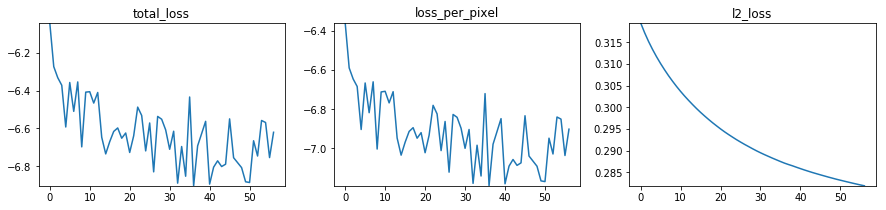

100%|██████████| 1000/1000 [04:17<00:00,  3.88it/s]


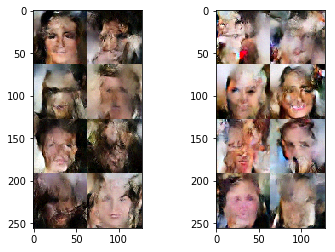

  5%|▌         | 50/1000 [00:13<04:12,  3.76it/s]

total_loss -6.606511
loss_per_pixel -6.8881826
l2_loss 0.28167132


 10%|█         | 100/1000 [00:26<03:55,  3.82it/s]

total_loss -6.8541417
loss_per_pixel -7.1356115
l2_loss 0.28146997


 15%|█▌        | 150/1000 [00:39<03:41,  3.83it/s]

total_loss -6.857641
loss_per_pixel -7.1389155
l2_loss 0.28127417


 20%|██        | 200/1000 [00:52<03:28,  3.85it/s]

total_loss -6.563369
loss_per_pixel -6.844451
l2_loss 0.2810822


 25%|██▌       | 250/1000 [01:04<03:14,  3.85it/s]

total_loss -6.8006105
loss_per_pixel -7.081503
l2_loss 0.28089213


 30%|███       | 300/1000 [01:18<03:02,  3.84it/s]

total_loss -6.8741865
loss_per_pixel -7.1549034
l2_loss 0.28071707


 35%|███▌      | 350/1000 [01:31<02:49,  3.84it/s]

total_loss -6.6304393
loss_per_pixel -6.9109726
l2_loss 0.28053316


 40%|████      | 400/1000 [01:43<02:35,  3.85it/s]

total_loss -6.7686396
loss_per_pixel -7.049001
l2_loss 0.28036174


 45%|████▌     | 450/1000 [01:56<02:22,  3.85it/s]

total_loss -6.682148
loss_per_pixel -6.962328
l2_loss 0.28017992


 50%|█████     | 500/1000 [02:09<02:09,  3.86it/s]

total_loss -6.6507754
loss_per_pixel -6.930789
l2_loss 0.28001374


 55%|█████▌    | 550/1000 [02:22<01:56,  3.86it/s]

total_loss -6.698092
loss_per_pixel -6.977928
l2_loss 0.27983606


 60%|██████    | 600/1000 [02:34<01:43,  3.87it/s]

total_loss -6.8457355
loss_per_pixel -7.1254015
l2_loss 0.27966607


 65%|██████▌   | 650/1000 [02:48<01:30,  3.87it/s]

total_loss -6.794809
loss_per_pixel -7.0743017
l2_loss 0.27949288


 70%|███████   | 700/1000 [03:01<01:17,  3.86it/s]

total_loss -6.771658
loss_per_pixel -7.0509796
l2_loss 0.2793219


 75%|███████▌  | 750/1000 [03:14<01:04,  3.86it/s]

total_loss -6.9215636
loss_per_pixel -7.20072
l2_loss 0.27915636


 80%|████████  | 800/1000 [03:26<00:51,  3.87it/s]

total_loss -6.8767066
loss_per_pixel -7.1557155
l2_loss 0.27900872


 85%|████████▌ | 850/1000 [03:39<00:38,  3.87it/s]

total_loss -6.8063974
loss_per_pixel -7.085238
l2_loss 0.27884054


 90%|█████████ | 900/1000 [03:52<00:25,  3.87it/s]

total_loss -6.5366473
loss_per_pixel -6.815322
l2_loss 0.2786744


 95%|█████████▌| 950/1000 [04:05<00:12,  3.87it/s]

total_loss -6.828846
loss_per_pixel -7.107362
l2_loss 0.27851567


100%|█████████▉| 999/1000 [04:17<00:00,  3.88it/s]

total_loss -6.7930064
loss_per_pixel -7.0713506
l2_loss 0.27834424


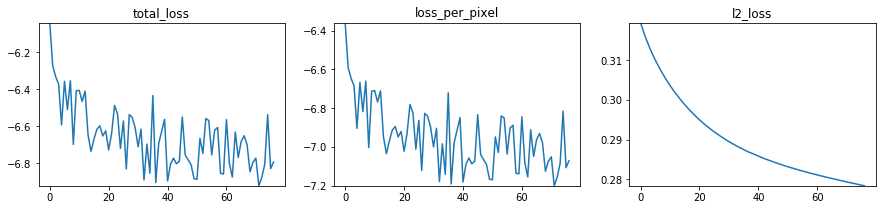

100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]


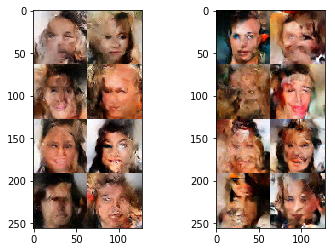

  5%|▌         | 50/1000 [00:12<04:00,  3.95it/s]

total_loss -6.7948046
loss_per_pixel -7.072997
l2_loss 0.2781926


 10%|█         | 100/1000 [00:26<03:55,  3.82it/s]

total_loss -6.9347715
loss_per_pixel -7.212803
l2_loss 0.27803153


 15%|█▌        | 150/1000 [00:39<03:41,  3.83it/s]

total_loss -6.8038664
loss_per_pixel -7.0817275
l2_loss 0.27786133


 20%|██        | 200/1000 [00:52<03:28,  3.84it/s]

total_loss -6.602866
loss_per_pixel -6.880571
l2_loss 0.27770466


 25%|██▌       | 250/1000 [01:04<03:14,  3.85it/s]

total_loss -6.7602873
loss_per_pixel -7.0378265
l2_loss 0.27753904


 30%|███       | 300/1000 [01:17<03:00,  3.87it/s]

total_loss -7.099874
loss_per_pixel -7.3772697
l2_loss 0.27739578


 35%|███▌      | 350/1000 [01:30<02:48,  3.86it/s]

total_loss -6.676767
loss_per_pixel -6.9540133
l2_loss 0.2772463


 40%|████      | 400/1000 [01:43<02:35,  3.87it/s]

total_loss -6.598843
loss_per_pixel -6.875925
l2_loss 0.27708194


 45%|████▌     | 450/1000 [01:55<02:21,  3.88it/s]

total_loss -6.7102175
loss_per_pixel -6.9871464
l2_loss 0.27692887


 50%|█████     | 500/1000 [02:08<02:08,  3.88it/s]

total_loss -6.484579
loss_per_pixel -6.761365
l2_loss 0.2767857


 55%|█████▌    | 550/1000 [02:22<01:56,  3.87it/s]

total_loss -6.644856
loss_per_pixel -6.921488
l2_loss 0.27663195


 60%|██████    | 600/1000 [02:34<01:43,  3.87it/s]

total_loss -6.9526463
loss_per_pixel -7.2291307
l2_loss 0.27648467


 65%|██████▌   | 650/1000 [02:48<01:30,  3.86it/s]

total_loss -6.8889375
loss_per_pixel -7.165258
l2_loss 0.27632025


 70%|███████   | 700/1000 [03:01<01:17,  3.86it/s]

total_loss -6.768499
loss_per_pixel -7.044669
l2_loss 0.2761703


 75%|███████▌  | 750/1000 [03:14<01:04,  3.86it/s]

total_loss -6.7709513
loss_per_pixel -7.0469694
l2_loss 0.276018


 80%|████████  | 800/1000 [03:27<00:51,  3.85it/s]

total_loss -6.72218
loss_per_pixel -6.998055
l2_loss 0.27587497


 85%|████████▌ | 850/1000 [03:40<00:38,  3.85it/s]

total_loss -6.7781253
loss_per_pixel -7.0538483
l2_loss 0.2757232


 90%|█████████ | 900/1000 [03:53<00:25,  3.86it/s]

total_loss -6.79276
loss_per_pixel -7.06833
l2_loss 0.27556995


 95%|█████████▌| 950/1000 [04:06<00:12,  3.86it/s]

total_loss -6.8509927
loss_per_pixel -7.1264086
l2_loss 0.2754158


100%|█████████▉| 999/1000 [04:18<00:00,  3.86it/s]

total_loss -6.7256093
loss_per_pixel -7.0008917
l2_loss 0.27528232


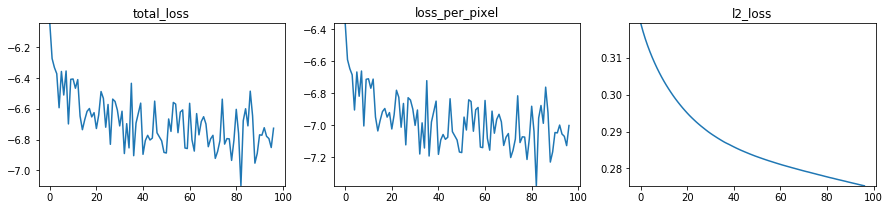

100%|██████████| 1000/1000 [04:19<00:00,  3.86it/s]


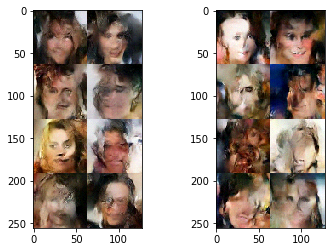

In [34]:
for i in range(5):
    utils.trainer(
        sess, 
        num_steps=1000,
        train_op=train_op, 
        feed_dict_fn=lambda: {lr_ph: 0.0005, beta_ph: 1.0}, 
        metrics=[metrics], 
        hooks=[plot_metrics_hook]
    )
    
    plt.subplot(121)
    plt.imshow(utils.plot_grid(x_flow_sampled_uint).eval({lr_ph: 0.0, beta_ph: 0.9}))
    plt.subplot(122)
    plt.imshow(utils.plot_grid(x_flow_sampled_uint).eval({lr_ph: 0.0, beta_ph: 1.0}))
    plt.show()

  5%|▌         | 50/1000 [00:12<04:04,  3.88it/s]

total_loss -6.8044567
loss_per_pixel -7.0796657
l2_loss 0.27520913


 10%|█         | 100/1000 [00:26<03:54,  3.84it/s]

total_loss -6.778297
loss_per_pixel -7.053432
l2_loss 0.27513492


 15%|█▌        | 150/1000 [00:38<03:40,  3.86it/s]

total_loss -6.776102
loss_per_pixel -7.0511656
l2_loss 0.27506366


 20%|██        | 200/1000 [00:51<03:27,  3.86it/s]

total_loss -6.928056
loss_per_pixel -7.203046
l2_loss 0.27498996


 25%|██▌       | 250/1000 [01:04<03:14,  3.86it/s]

total_loss -6.863495
loss_per_pixel -7.1384134
l2_loss 0.2749185


 30%|███       | 300/1000 [01:17<03:01,  3.86it/s]

total_loss -6.8792562
loss_per_pixel -7.1541023
l2_loss 0.27484626


 35%|███▌      | 350/1000 [01:30<02:47,  3.87it/s]

total_loss -6.8717594
loss_per_pixel -7.1465316
l2_loss 0.27477196


 40%|████      | 400/1000 [01:43<02:34,  3.87it/s]

total_loss -6.7409286
loss_per_pixel -7.0156264
l2_loss 0.27469787


 45%|████▌     | 450/1000 [01:56<02:22,  3.85it/s]

total_loss -7.0154734
loss_per_pixel -7.290102
l2_loss 0.2746284


 50%|█████     | 500/1000 [02:09<02:09,  3.85it/s]

total_loss -6.805516
loss_per_pixel -7.0800724
l2_loss 0.27455655


 55%|█████▌    | 550/1000 [02:22<01:56,  3.85it/s]

total_loss -6.8920865
loss_per_pixel -7.166574
l2_loss 0.27448767


 60%|██████    | 600/1000 [02:35<01:43,  3.86it/s]

total_loss -7.1280046
loss_per_pixel -7.402423
l2_loss 0.27441847


 65%|██████▌   | 650/1000 [02:48<01:30,  3.85it/s]

total_loss -6.6173925
loss_per_pixel -6.89174
l2_loss 0.27434754


 70%|███████   | 700/1000 [03:01<01:17,  3.86it/s]

total_loss -6.803681
loss_per_pixel -7.077958
l2_loss 0.2742774


 75%|███████▌  | 750/1000 [03:14<01:04,  3.86it/s]

total_loss -6.835649
loss_per_pixel -7.109861
l2_loss 0.27421182


 80%|████████  | 800/1000 [03:27<00:51,  3.86it/s]

total_loss -6.654603
loss_per_pixel -6.928747
l2_loss 0.2741442


 85%|████████▌ | 850/1000 [03:40<00:38,  3.86it/s]

total_loss -6.852254
loss_per_pixel -7.126332
l2_loss 0.2740778


 90%|█████████ | 900/1000 [03:52<00:25,  3.87it/s]

total_loss -6.999532
loss_per_pixel -7.2735443
l2_loss 0.2740121


 95%|█████████▌| 950/1000 [04:05<00:12,  3.87it/s]

total_loss -6.8792596
loss_per_pixel -7.153205
l2_loss 0.27394542


100%|█████████▉| 999/1000 [04:18<00:00,  3.86it/s]

total_loss -6.709268
loss_per_pixel -6.9831476
l2_loss 0.27387935


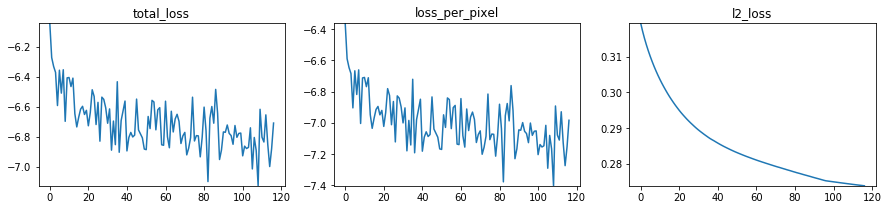

100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]


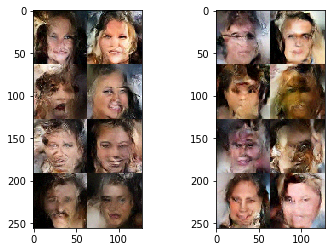

  5%|▌         | 50/1000 [00:13<04:07,  3.84it/s]

total_loss -7.0730443
loss_per_pixel -7.346858
l2_loss 0.27381364


 10%|█         | 100/1000 [00:25<03:51,  3.89it/s]

total_loss -6.784796
loss_per_pixel -7.058544
l2_loss 0.2737478


 15%|█▌        | 150/1000 [00:38<03:39,  3.88it/s]

total_loss -6.799374
loss_per_pixel -7.0730553
l2_loss 0.27368134


 20%|██        | 200/1000 [00:52<03:28,  3.84it/s]

total_loss -6.9181576
loss_per_pixel -7.1917763
l2_loss 0.27361852


 25%|██▌       | 250/1000 [01:04<03:14,  3.86it/s]

total_loss -6.813934
loss_per_pixel -7.0874863
l2_loss 0.27355254


 30%|███       | 300/1000 [01:17<03:00,  3.88it/s]

total_loss -6.9619555
loss_per_pixel -7.2354445
l2_loss 0.2734888


 35%|███▌      | 350/1000 [01:30<02:47,  3.88it/s]

total_loss -6.7943482
loss_per_pixel -7.0677757
l2_loss 0.2734275


 40%|████      | 400/1000 [01:43<02:34,  3.88it/s]

total_loss -6.704236
loss_per_pixel -6.977601
l2_loss 0.27336508


 45%|████▌     | 450/1000 [01:56<02:22,  3.87it/s]

total_loss -6.655816
loss_per_pixel -6.929119
l2_loss 0.27330303


 50%|█████     | 500/1000 [02:09<02:09,  3.87it/s]

total_loss -6.761576
loss_per_pixel -7.0348167
l2_loss 0.27324063


 55%|█████▌    | 550/1000 [02:22<01:56,  3.87it/s]

total_loss -7.0297937
loss_per_pixel -7.3029723
l2_loss 0.27317867


 60%|██████    | 600/1000 [02:34<01:43,  3.87it/s]

total_loss -6.772126
loss_per_pixel -7.045244
l2_loss 0.2731181


 65%|██████▌   | 650/1000 [02:48<01:30,  3.87it/s]

total_loss -6.8430147
loss_per_pixel -7.1160727
l2_loss 0.2730579


 70%|███████   | 700/1000 [03:01<01:17,  3.86it/s]

total_loss -6.9846354
loss_per_pixel -7.257633
l2_loss 0.27299783


 75%|███████▌  | 750/1000 [03:14<01:04,  3.86it/s]

total_loss -6.977303
loss_per_pixel -7.2502413
l2_loss 0.27293807


 80%|████████  | 800/1000 [03:26<00:51,  3.87it/s]

total_loss -6.8137765
loss_per_pixel -7.0866528
l2_loss 0.27287617


 85%|████████▌ | 850/1000 [03:39<00:38,  3.87it/s]

total_loss -6.88402
loss_per_pixel -7.156838
l2_loss 0.27281815


 90%|█████████ | 900/1000 [03:52<00:25,  3.88it/s]

total_loss -6.7155986
loss_per_pixel -6.9883566
l2_loss 0.27275807


 95%|█████████▌| 950/1000 [04:04<00:12,  3.88it/s]

total_loss -7.056547
loss_per_pixel -7.3292484
l2_loss 0.27270147


100%|█████████▉| 999/1000 [04:17<00:00,  3.88it/s]

total_loss -7.185934
loss_per_pixel -7.4585752
l2_loss 0.2726413


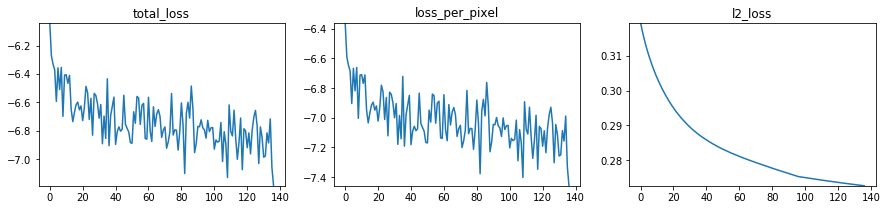

100%|██████████| 1000/1000 [04:18<00:00,  3.88it/s]


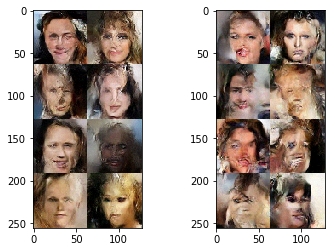

  5%|▌         | 50/1000 [00:12<04:00,  3.95it/s]

total_loss -6.9686365
loss_per_pixel -7.241221
l2_loss 0.27258468


 10%|█         | 100/1000 [00:25<03:49,  3.92it/s]

total_loss -6.725515
loss_per_pixel -6.998042
l2_loss 0.27252734


 15%|█▌        | 150/1000 [00:37<03:33,  3.98it/s]

total_loss -7.118982
loss_per_pixel -7.3914537
l2_loss 0.2724721


 20%|██        | 200/1000 [00:50<03:20,  3.98it/s]

total_loss -6.9820437
loss_per_pixel -7.254459
l2_loss 0.27241507


 25%|██▌       | 250/1000 [01:02<03:08,  3.97it/s]

total_loss -6.787482
loss_per_pixel -7.0598426
l2_loss 0.27236065


 30%|███       | 300/1000 [01:15<02:56,  3.97it/s]

total_loss -6.7735844
loss_per_pixel -7.045887
l2_loss 0.27230263


 35%|███▌      | 350/1000 [01:28<02:44,  3.94it/s]

total_loss -6.994948
loss_per_pixel -7.267196
l2_loss 0.2722482


 40%|████      | 400/1000 [01:42<02:33,  3.91it/s]

total_loss -6.937933
loss_per_pixel -7.2101274
l2_loss 0.27219418


 45%|████▌     | 450/1000 [01:54<02:20,  3.91it/s]

total_loss -6.7704988
loss_per_pixel -7.042638
l2_loss 0.27213925


 50%|█████     | 500/1000 [02:08<02:08,  3.90it/s]

total_loss -6.7359304
loss_per_pixel -7.0080147
l2_loss 0.27208415


 55%|█████▌    | 550/1000 [02:21<01:55,  3.90it/s]

total_loss -6.932019
loss_per_pixel -7.20405
l2_loss 0.27203068


 60%|██████    | 600/1000 [02:34<01:42,  3.89it/s]

total_loss -6.7508464
loss_per_pixel -7.0228233
l2_loss 0.27197707


 65%|██████▌   | 650/1000 [02:47<01:29,  3.89it/s]

total_loss -6.757111
loss_per_pixel -7.0290318
l2_loss 0.2719208


 70%|███████   | 700/1000 [02:59<01:16,  3.90it/s]

total_loss -6.8851175
loss_per_pixel -7.156985
l2_loss 0.27186745


 75%|███████▌  | 750/1000 [03:12<01:04,  3.90it/s]

total_loss -6.962439
loss_per_pixel -7.234254
l2_loss 0.27181476


 80%|████████  | 800/1000 [03:25<00:51,  3.89it/s]

total_loss -6.6591268
loss_per_pixel -6.930888
l2_loss 0.27176163


 85%|████████▌ | 850/1000 [03:38<00:38,  3.89it/s]

total_loss -7.017466
loss_per_pixel -7.289176
l2_loss 0.27170992


 90%|█████████ | 900/1000 [03:50<00:25,  3.90it/s]

total_loss -7.1362166
loss_per_pixel -7.4078727
l2_loss 0.27165624


 95%|█████████▌| 950/1000 [04:03<00:12,  3.90it/s]

total_loss -6.8377934
loss_per_pixel -7.109397
l2_loss 0.2716038


100%|█████████▉| 999/1000 [04:16<00:00,  3.90it/s]

total_loss -6.82794
loss_per_pixel -7.099492
l2_loss 0.27155197


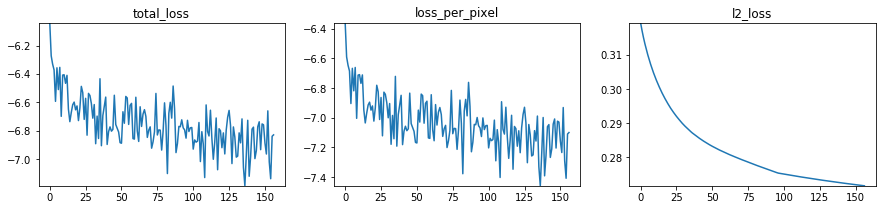

100%|██████████| 1000/1000 [04:16<00:00,  3.90it/s]


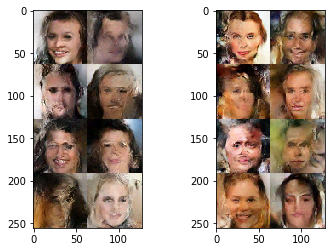

  5%|▌         | 50/1000 [00:13<04:08,  3.82it/s]

total_loss -6.9822063
loss_per_pixel -7.253706
l2_loss 0.27149945


 10%|█         | 100/1000 [00:25<03:52,  3.87it/s]

total_loss -6.917637
loss_per_pixel -7.189087
l2_loss 0.2714499


 15%|█▌        | 150/1000 [00:38<03:37,  3.90it/s]

total_loss -7.007705
loss_per_pixel -7.279103
l2_loss 0.27139744


 20%|██        | 200/1000 [00:51<03:27,  3.86it/s]

total_loss -6.9060354
loss_per_pixel -7.1773815
l2_loss 0.27134624


 25%|██▌       | 250/1000 [01:04<03:13,  3.87it/s]

total_loss -6.848941
loss_per_pixel -7.120234
l2_loss 0.2712934


 30%|███       | 300/1000 [01:17<03:00,  3.88it/s]

total_loss -6.976772
loss_per_pixel -7.248016
l2_loss 0.27124384


 35%|███▌      | 350/1000 [01:30<02:47,  3.88it/s]

total_loss -7.095056
loss_per_pixel -7.366251
l2_loss 0.27119488


 40%|████      | 400/1000 [01:43<02:34,  3.88it/s]

total_loss -6.954314
loss_per_pixel -7.2254577
l2_loss 0.2711432


 45%|████▌     | 450/1000 [01:56<02:21,  3.87it/s]

total_loss -6.851853
loss_per_pixel -7.122945
l2_loss 0.27109212


 50%|█████     | 500/1000 [02:08<02:08,  3.89it/s]

total_loss -6.9358616
loss_per_pixel -7.2069035
l2_loss 0.27104202


 55%|█████▌    | 550/1000 [02:21<01:55,  3.89it/s]

total_loss -7.0245423
loss_per_pixel -7.295532
l2_loss 0.27098987


 60%|██████    | 600/1000 [02:34<01:43,  3.87it/s]

total_loss -6.842194
loss_per_pixel -7.1131334
l2_loss 0.27093932


 65%|██████▌   | 650/1000 [02:47<01:30,  3.88it/s]

total_loss -6.9116096
loss_per_pixel -7.1825004
l2_loss 0.2708908


 70%|███████   | 700/1000 [03:00<01:17,  3.88it/s]

total_loss -6.987584
loss_per_pixel -7.258427
l2_loss 0.2708429


 75%|███████▌  | 750/1000 [03:12<01:04,  3.89it/s]

total_loss -6.9671793
loss_per_pixel -7.2379723
l2_loss 0.2707928


 80%|████████  | 800/1000 [03:26<00:51,  3.88it/s]

total_loss -6.9999895
loss_per_pixel -7.2707324
l2_loss 0.27074313


 85%|████████▌ | 850/1000 [03:38<00:38,  3.88it/s]

total_loss -6.79675
loss_per_pixel -7.0674458
l2_loss 0.2706955


 90%|█████████ | 900/1000 [03:51<00:25,  3.89it/s]

total_loss -6.775632
loss_per_pixel -7.046279
l2_loss 0.27064723


 95%|█████████▌| 950/1000 [04:04<00:12,  3.88it/s]

total_loss -7.0185556
loss_per_pixel -7.289157
l2_loss 0.27060106


100%|█████████▉| 999/1000 [04:16<00:00,  3.89it/s]

total_loss -6.7144375
loss_per_pixel -6.9849863
l2_loss 0.2705487


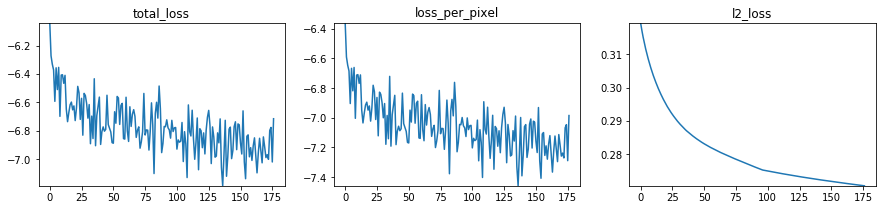

100%|██████████| 1000/1000 [04:17<00:00,  3.88it/s]


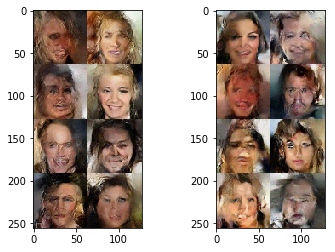

  5%|▌         | 50/1000 [00:12<04:04,  3.89it/s]

total_loss -6.9089975
loss_per_pixel -7.1794977
l2_loss 0.27050015


 10%|█         | 100/1000 [00:25<03:50,  3.91it/s]

total_loss -6.718578
loss_per_pixel -6.989029
l2_loss 0.27045113


 15%|█▌        | 150/1000 [00:38<03:37,  3.91it/s]

total_loss -6.9066396
loss_per_pixel -7.177041
l2_loss 0.27040163


 20%|██        | 200/1000 [00:51<03:25,  3.89it/s]

total_loss -6.7603307
loss_per_pixel -7.030686
l2_loss 0.27035522


 25%|██▌       | 250/1000 [01:04<03:13,  3.88it/s]

total_loss -6.872831
loss_per_pixel -7.143137
l2_loss 0.2703059


 30%|███       | 300/1000 [01:17<03:01,  3.86it/s]

total_loss -7.011853
loss_per_pixel -7.282111
l2_loss 0.2702578


 35%|███▌      | 350/1000 [01:30<02:47,  3.87it/s]

total_loss -6.815963
loss_per_pixel -7.0861735
l2_loss 0.27021062


 40%|████      | 400/1000 [01:42<02:34,  3.88it/s]

total_loss -7.265972
loss_per_pixel -7.536134
l2_loss 0.27016145


 45%|████▌     | 450/1000 [01:55<02:21,  3.88it/s]

total_loss -6.9519315
loss_per_pixel -7.2220473
l2_loss 0.27011573


 50%|█████     | 500/1000 [02:08<02:08,  3.88it/s]

total_loss -6.842369
loss_per_pixel -7.112439
l2_loss 0.27007025


 55%|█████▌    | 550/1000 [02:21<01:55,  3.89it/s]

total_loss -6.959961
loss_per_pixel -7.2299814
l2_loss 0.2700207


 60%|██████    | 600/1000 [02:33<01:42,  3.90it/s]

total_loss -6.833592
loss_per_pixel -7.103568
l2_loss 0.26997632


 65%|██████▌   | 650/1000 [02:46<01:29,  3.90it/s]

total_loss -6.736086
loss_per_pixel -7.0060167
l2_loss 0.26993108


 70%|███████   | 700/1000 [02:59<01:16,  3.90it/s]

total_loss -6.9194174
loss_per_pixel -7.1893024
l2_loss 0.2698853


 75%|███████▌  | 750/1000 [03:12<01:04,  3.90it/s]

total_loss -7.0075197
loss_per_pixel -7.277358
l2_loss 0.26983848


 80%|████████  | 800/1000 [03:24<00:51,  3.90it/s]

total_loss -7.0062313
loss_per_pixel -7.276025
l2_loss 0.2697936


 85%|████████▌ | 850/1000 [03:38<00:38,  3.90it/s]

total_loss -6.895965
loss_per_pixel -7.165713
l2_loss 0.26974759


 90%|█████████ | 900/1000 [03:51<00:25,  3.89it/s]

total_loss -6.9069705
loss_per_pixel -7.1766715
l2_loss 0.269701


 95%|█████████▌| 950/1000 [04:04<00:12,  3.89it/s]

total_loss -6.942189
loss_per_pixel -7.211845
l2_loss 0.26965576


100%|█████████▉| 999/1000 [04:17<00:00,  3.88it/s]

total_loss -6.978216
loss_per_pixel -7.2478266
l2_loss 0.26961064


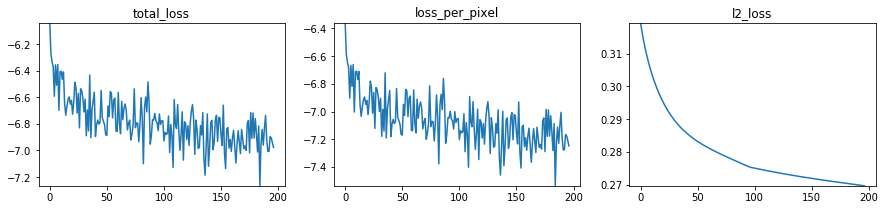

100%|██████████| 1000/1000 [04:18<00:00,  3.88it/s]


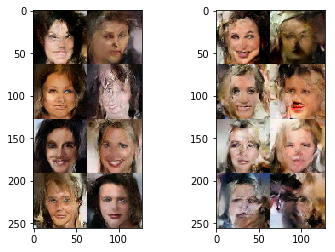

In [35]:
for i in range(5):
    utils.trainer(
        sess, 
        num_steps=1000,
        train_op=train_op, 
        feed_dict_fn=lambda: {lr_ph: 0.0001, beta_ph: 1.0}, 
        metrics=[metrics], 
        hooks=[plot_metrics_hook]
    )
    
    plt.subplot(121)
    plt.imshow(utils.plot_grid(x_flow_sampled_uint).eval({lr_ph: 0.0, beta_ph: 0.9}))
    plt.subplot(122)
    plt.imshow(utils.plot_grid(x_flow_sampled_uint).eval({lr_ph: 0.0, beta_ph: 1.0}))
    plt.show()

  5%|▌         | 50/1000 [00:12<04:05,  3.88it/s]

total_loss -6.883038
loss_per_pixel -7.152622
l2_loss 0.26958424


 10%|█         | 100/1000 [00:25<03:48,  3.94it/s]

total_loss -6.9721594
loss_per_pixel -7.2417164
l2_loss 0.2695572


 15%|█▌        | 150/1000 [00:38<03:37,  3.91it/s]

total_loss -6.857773
loss_per_pixel -7.1273055
l2_loss 0.26953283


 20%|██        | 200/1000 [00:51<03:25,  3.90it/s]

total_loss -7.0566974
loss_per_pixel -7.3262024
l2_loss 0.26950496


 25%|██▌       | 250/1000 [01:04<03:12,  3.90it/s]

total_loss -6.793455
loss_per_pixel -7.062934
l2_loss 0.26947865


 30%|███       | 300/1000 [01:17<02:59,  3.89it/s]

total_loss -6.971408
loss_per_pixel -7.24086
l2_loss 0.26945224


 35%|███▌      | 350/1000 [01:29<02:46,  3.90it/s]

total_loss -6.9196854
loss_per_pixel -7.1891127
l2_loss 0.26942745


 40%|████      | 400/1000 [01:42<02:34,  3.89it/s]

total_loss -6.871577
loss_per_pixel -7.1409764
l2_loss 0.26939952


 45%|████▌     | 450/1000 [01:55<02:21,  3.89it/s]

total_loss -6.775287
loss_per_pixel -7.0446606
l2_loss 0.26937336


 50%|█████     | 500/1000 [02:08<02:08,  3.89it/s]

total_loss -6.8286476
loss_per_pixel -7.0979953
l2_loss 0.26934773


 55%|█████▌    | 550/1000 [02:21<01:56,  3.88it/s]

total_loss -6.9412036
loss_per_pixel -7.2105255
l2_loss 0.26932213


 60%|██████    | 600/1000 [02:35<01:43,  3.87it/s]

total_loss -6.8662033
loss_per_pixel -7.1355
l2_loss 0.26929685


 65%|██████▌   | 650/1000 [02:47<01:30,  3.87it/s]

total_loss -6.7622
loss_per_pixel -7.031471
l2_loss 0.269271


 70%|███████   | 700/1000 [03:00<01:17,  3.87it/s]

total_loss -6.871922
loss_per_pixel -7.1411676
l2_loss 0.26924554


 75%|███████▌  | 750/1000 [03:13<01:04,  3.87it/s]

total_loss -6.7931285
loss_per_pixel -7.0623474
l2_loss 0.26921874


 80%|████████  | 800/1000 [03:26<00:51,  3.88it/s]

total_loss -6.822952
loss_per_pixel -7.092145
l2_loss 0.26919314


 85%|████████▌ | 850/1000 [03:38<00:38,  3.88it/s]

total_loss -6.97123
loss_per_pixel -7.2403984
l2_loss 0.26916847


 90%|█████████ | 900/1000 [03:51<00:25,  3.88it/s]

total_loss -6.717466
loss_per_pixel -6.9866066
l2_loss 0.26914072


 95%|█████████▌| 950/1000 [04:05<00:12,  3.88it/s]

total_loss -7.057655
loss_per_pixel -7.3267713
l2_loss 0.2691163


100%|█████████▉| 999/1000 [04:18<00:00,  3.87it/s]

total_loss -6.847701
loss_per_pixel -7.1167936
l2_loss 0.26909274


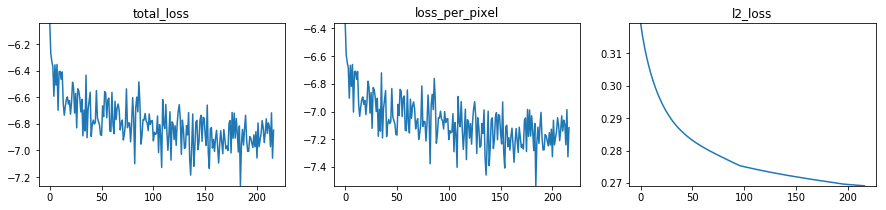

100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]


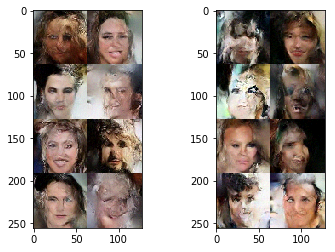

  5%|▌         | 50/1000 [00:13<04:08,  3.82it/s]

total_loss -6.8018036
loss_per_pixel -7.0708714
l2_loss 0.26906765


 10%|█         | 100/1000 [00:25<03:49,  3.93it/s]

total_loss -6.788018
loss_per_pixel -7.0570602
l2_loss 0.26904193


 15%|█▌        | 150/1000 [00:38<03:36,  3.92it/s]

total_loss -6.9694886
loss_per_pixel -7.2385054
l2_loss 0.26901656


 20%|██        | 200/1000 [00:50<03:23,  3.93it/s]

total_loss -6.618848
loss_per_pixel -6.887839
l2_loss 0.2689912


 25%|██▌       | 250/1000 [01:03<03:10,  3.93it/s]

total_loss -6.850994
loss_per_pixel -7.119959
l2_loss 0.26896474


 30%|███       | 300/1000 [01:16<02:58,  3.93it/s]

total_loss -6.7715435
loss_per_pixel -7.040484
l2_loss 0.26894024


 35%|███▌      | 350/1000 [01:28<02:45,  3.94it/s]

total_loss -6.983218
loss_per_pixel -7.2521343
l2_loss 0.26891607


 40%|████      | 400/1000 [01:42<02:33,  3.91it/s]

total_loss -6.8745766
loss_per_pixel -7.143468
l2_loss 0.26889133


 45%|████▌     | 450/1000 [01:55<02:21,  3.90it/s]

total_loss -6.830675
loss_per_pixel -7.0995407
l2_loss 0.26886564


 50%|█████     | 500/1000 [02:08<02:08,  3.90it/s]

total_loss -7.044908
loss_per_pixel -7.313748
l2_loss 0.26883987


 55%|█████▌    | 550/1000 [02:20<01:55,  3.90it/s]

total_loss -6.941955
loss_per_pixel -7.2107706
l2_loss 0.2688154


 60%|██████    | 600/1000 [02:33<01:42,  3.90it/s]

total_loss -6.8897533
loss_per_pixel -7.1585445
l2_loss 0.26879114


 65%|██████▌   | 650/1000 [02:46<01:29,  3.89it/s]

total_loss -6.8003817
loss_per_pixel -7.0691476
l2_loss 0.26876578


 70%|███████   | 700/1000 [03:00<01:17,  3.88it/s]

total_loss -6.59491
loss_per_pixel -6.8636527
l2_loss 0.26874256


 75%|███████▌  | 750/1000 [03:13<01:04,  3.88it/s]

total_loss -6.772904
loss_per_pixel -7.0416217
l2_loss 0.26871783


 80%|████████  | 800/1000 [03:25<00:51,  3.89it/s]

total_loss -6.9089317
loss_per_pixel -7.177626
l2_loss 0.26869416


 85%|████████▌ | 850/1000 [03:38<00:38,  3.89it/s]

total_loss -6.670493
loss_per_pixel -6.9391613
l2_loss 0.26866817


 90%|█████████ | 900/1000 [03:50<00:25,  3.90it/s]

total_loss -6.8561625
loss_per_pixel -7.1248074
l2_loss 0.268645


 95%|█████████▌| 950/1000 [04:03<00:12,  3.89it/s]

total_loss -7.003864
loss_per_pixel -7.2724843
l2_loss 0.2686203


100%|█████████▉| 999/1000 [04:16<00:00,  3.89it/s]

total_loss -6.8326316
loss_per_pixel -7.1012273
l2_loss 0.26859584


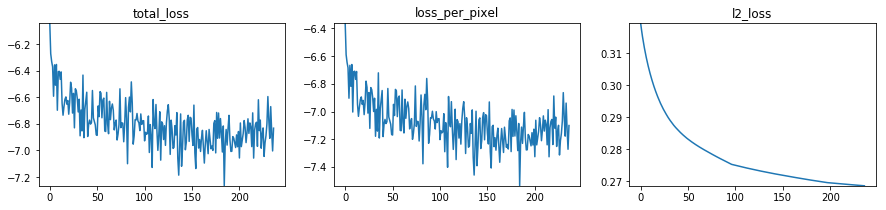

100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s]


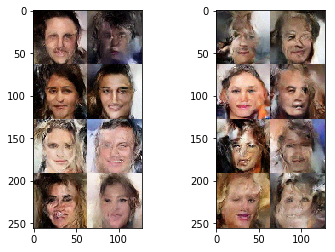

  5%|▌         | 50/1000 [00:12<04:03,  3.90it/s]

total_loss -6.915799
loss_per_pixel -7.18437
l2_loss 0.26857078


 10%|█         | 100/1000 [00:25<03:51,  3.90it/s]

total_loss -6.7618365
loss_per_pixel -7.030383
l2_loss 0.2685465


 15%|█▌        | 150/1000 [00:38<03:37,  3.91it/s]

total_loss -7.0715876
loss_per_pixel -7.34011
l2_loss 0.2685223


 20%|██        | 200/1000 [00:51<03:25,  3.89it/s]

total_loss -7.150391
loss_per_pixel -7.4188895
l2_loss 0.26849848


 25%|██▌       | 250/1000 [01:04<03:14,  3.85it/s]

total_loss -6.871403
loss_per_pixel -7.1398764
l2_loss 0.26847327


 30%|███       | 300/1000 [01:18<03:03,  3.82it/s]

total_loss -6.876245
loss_per_pixel -7.1446953
l2_loss 0.26845035


 35%|███▌      | 350/1000 [01:31<02:50,  3.82it/s]

total_loss -6.9929605
loss_per_pixel -7.261387
l2_loss 0.2684263


 40%|████      | 400/1000 [01:44<02:36,  3.84it/s]

total_loss -7.0158906
loss_per_pixel -7.284293
l2_loss 0.2684025


 45%|████▌     | 450/1000 [01:57<02:23,  3.84it/s]

total_loss -6.8976226
loss_per_pixel -7.166001
l2_loss 0.26837847


 50%|█████     | 500/1000 [02:09<02:09,  3.87it/s]

total_loss -6.8938494
loss_per_pixel -7.1622043
l2_loss 0.26835495


 55%|█████▌    | 550/1000 [02:21<01:56,  3.88it/s]

total_loss -6.857779
loss_per_pixel -7.126108
l2_loss 0.26832932


 60%|██████    | 600/1000 [02:35<01:43,  3.87it/s]

total_loss -6.8612595
loss_per_pixel -7.1295667
l2_loss 0.268307


 65%|██████▌   | 650/1000 [02:47<01:30,  3.88it/s]

total_loss -6.8628683
loss_per_pixel -7.1311502
l2_loss 0.26828188


 70%|███████   | 700/1000 [03:00<01:17,  3.88it/s]

total_loss -6.74217
loss_per_pixel -7.0104284
l2_loss 0.26825848


 75%|███████▌  | 750/1000 [03:13<01:04,  3.88it/s]

total_loss -6.8462286
loss_per_pixel -7.114464
l2_loss 0.26823542


 80%|████████  | 800/1000 [03:25<00:51,  3.89it/s]

total_loss -6.64035
loss_per_pixel -6.9085608
l2_loss 0.26821074


 85%|████████▌ | 850/1000 [03:38<00:38,  3.89it/s]

total_loss -6.9960756
loss_per_pixel -7.264263
l2_loss 0.26818758


 90%|█████████ | 900/1000 [03:51<00:25,  3.90it/s]

total_loss -6.849637
loss_per_pixel -7.117801
l2_loss 0.26816437


 95%|█████████▌| 950/1000 [04:04<00:12,  3.89it/s]

total_loss -7.1006927
loss_per_pixel -7.3688335
l2_loss 0.26814064


100%|█████████▉| 999/1000 [04:16<00:00,  3.90it/s]

total_loss -7.1054378
loss_per_pixel -7.373555
l2_loss 0.2681173


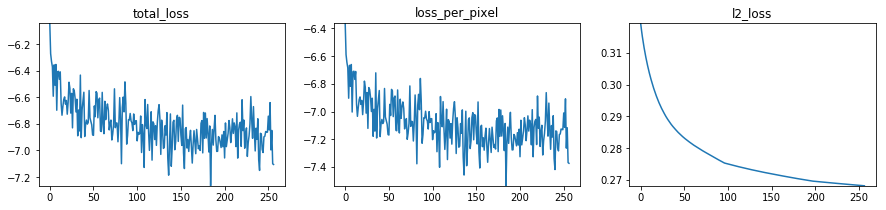

100%|██████████| 1000/1000 [04:16<00:00,  3.90it/s]


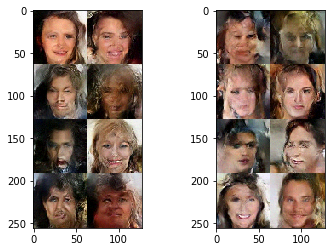

  5%|▌         | 50/1000 [00:12<04:01,  3.94it/s]

total_loss -7.0275626
loss_per_pixel -7.295656
l2_loss 0.26809353


 10%|█         | 100/1000 [00:25<03:48,  3.94it/s]

total_loss -6.825753
loss_per_pixel -7.0938234
l2_loss 0.2680702


 15%|█▌        | 150/1000 [00:38<03:35,  3.94it/s]

total_loss -6.9300275
loss_per_pixel -7.1980734
l2_loss 0.26804584


 20%|██        | 200/1000 [00:50<03:23,  3.93it/s]

total_loss -7.003895
loss_per_pixel -7.271918
l2_loss 0.268023


 25%|██▌       | 250/1000 [01:03<03:10,  3.93it/s]

total_loss -6.879288
loss_per_pixel -7.147288
l2_loss 0.26799977


 30%|███       | 300/1000 [01:16<02:58,  3.92it/s]

total_loss -6.8746905
loss_per_pixel -7.142667
l2_loss 0.26797608


 35%|███▌      | 350/1000 [01:29<02:46,  3.91it/s]

total_loss -6.7371325
loss_per_pixel -7.005086
l2_loss 0.26795322


 40%|████      | 400/1000 [01:42<02:33,  3.92it/s]

total_loss -6.90268
loss_per_pixel -7.1706085
l2_loss 0.2679285


 45%|████▌     | 450/1000 [01:55<02:21,  3.90it/s]

total_loss -6.9095573
loss_per_pixel -7.177463
l2_loss 0.26790565


 50%|█████     | 500/1000 [02:08<02:08,  3.90it/s]

total_loss -6.8080153
loss_per_pixel -7.075897
l2_loss 0.26788178


 55%|█████▌    | 550/1000 [02:21<01:55,  3.90it/s]

total_loss -6.9548817
loss_per_pixel -7.222741
l2_loss 0.26785967


 60%|██████    | 600/1000 [02:33<01:42,  3.90it/s]

total_loss -6.9120417
loss_per_pixel -7.1798787
l2_loss 0.26783705


 65%|██████▌   | 650/1000 [02:46<01:29,  3.91it/s]

total_loss -6.7934165
loss_per_pixel -7.0612297
l2_loss 0.26781327


 70%|███████   | 700/1000 [02:59<01:16,  3.91it/s]

total_loss -6.796419
loss_per_pixel -7.0642104
l2_loss 0.2677912


 75%|███████▌  | 750/1000 [03:12<01:04,  3.90it/s]

total_loss -6.7732143
loss_per_pixel -7.0409822
l2_loss 0.26776809


 80%|████████  | 800/1000 [03:24<00:51,  3.91it/s]

total_loss -6.836463
loss_per_pixel -7.104207
l2_loss 0.2677443


 85%|████████▌ | 850/1000 [03:37<00:38,  3.90it/s]

total_loss -7.0848355
loss_per_pixel -7.352558
l2_loss 0.2677224


 90%|█████████ | 900/1000 [03:50<00:25,  3.91it/s]

total_loss -6.924144
loss_per_pixel -7.1918435
l2_loss 0.26769963


 95%|█████████▌| 950/1000 [04:02<00:12,  3.91it/s]

total_loss -7.021563
loss_per_pixel -7.28924
l2_loss 0.2676768


100%|█████████▉| 999/1000 [04:15<00:00,  3.91it/s]

total_loss -6.9755483
loss_per_pixel -7.2432017
l2_loss 0.26765355


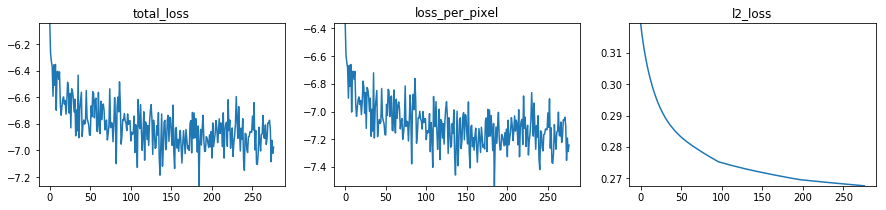

100%|██████████| 1000/1000 [04:15<00:00,  3.91it/s]


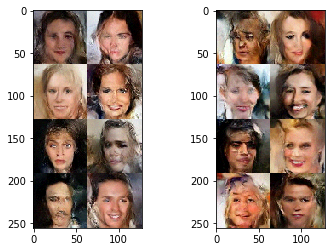

  5%|▌         | 50/1000 [00:12<03:56,  4.01it/s]

total_loss -6.843443
loss_per_pixel -7.1110725
l2_loss 0.26762938


 10%|█         | 100/1000 [00:25<03:50,  3.91it/s]

total_loss -6.929128
loss_per_pixel -7.1967373
l2_loss 0.26760918


 15%|█▌        | 150/1000 [00:38<03:38,  3.89it/s]

total_loss -7.0248027
loss_per_pixel -7.292388
l2_loss 0.2675854


 20%|██        | 200/1000 [00:51<03:24,  3.91it/s]

total_loss -6.673332
loss_per_pixel -6.940894
l2_loss 0.26756215


 25%|██▌       | 250/1000 [01:03<03:11,  3.93it/s]

total_loss -7.0643253
loss_per_pixel -7.331866
l2_loss 0.26754022


 30%|███       | 300/1000 [01:16<02:57,  3.94it/s]

total_loss -6.991322
loss_per_pixel -7.2588387
l2_loss 0.26751646


 35%|███▌      | 350/1000 [01:28<02:44,  3.96it/s]

total_loss -6.766882
loss_per_pixel -7.034376
l2_loss 0.26749402


 40%|████      | 400/1000 [01:41<02:32,  3.94it/s]

total_loss -6.8523617
loss_per_pixel -7.119834
l2_loss 0.26747206


 45%|████▌     | 450/1000 [01:53<02:19,  3.95it/s]

total_loss -7.0228434
loss_per_pixel -7.290293
l2_loss 0.26744983


 50%|█████     | 500/1000 [02:06<02:06,  3.95it/s]

total_loss -6.8954973
loss_per_pixel -7.162923
l2_loss 0.26742545


 55%|█████▌    | 550/1000 [02:19<01:54,  3.94it/s]

total_loss -6.9487467
loss_per_pixel -7.2161493
l2_loss 0.26740286


 60%|██████    | 600/1000 [02:32<01:41,  3.94it/s]

total_loss -6.920866
loss_per_pixel -7.1882477
l2_loss 0.26738182


 65%|██████▌   | 650/1000 [02:45<01:29,  3.92it/s]

total_loss -7.014099
loss_per_pixel -7.2814574
l2_loss 0.2673582


 70%|███████   | 700/1000 [02:58<01:16,  3.92it/s]

total_loss -6.8327556
loss_per_pixel -7.1000934
l2_loss 0.267338


 75%|███████▌  | 750/1000 [03:11<01:03,  3.92it/s]

total_loss -6.7995505
loss_per_pixel -7.066865
l2_loss 0.26731452


 80%|████████  | 800/1000 [03:23<00:50,  3.93it/s]

total_loss -7.0598993
loss_per_pixel -7.327192
l2_loss 0.26729244


 85%|████████▌ | 850/1000 [03:36<00:38,  3.93it/s]

total_loss -6.8504834
loss_per_pixel -7.117754
l2_loss 0.2672707


 90%|█████████ | 900/1000 [03:49<00:25,  3.93it/s]

total_loss -7.1726055
loss_per_pixel -7.439855
l2_loss 0.26724973


 95%|█████████▌| 950/1000 [04:02<00:12,  3.92it/s]

total_loss -6.9694686
loss_per_pixel -7.236696
l2_loss 0.26722705


100%|█████████▉| 999/1000 [04:14<00:00,  3.93it/s]

total_loss -6.9395127
loss_per_pixel -7.206717
l2_loss 0.2672041


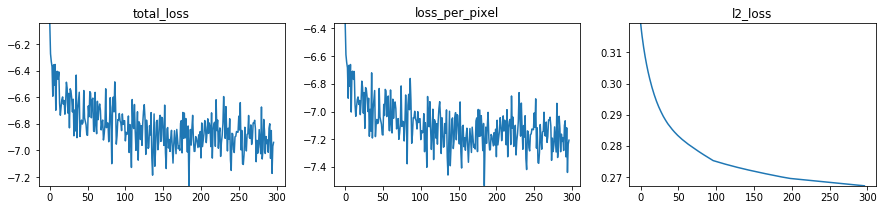

100%|██████████| 1000/1000 [04:15<00:00,  3.92it/s]


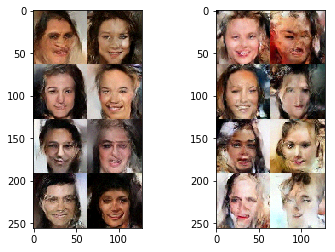

In [36]:
for i in range(5):
    utils.trainer(
        sess, 
        num_steps=1000, 
        train_op=train_op, 
        feed_dict_fn=lambda: {lr_ph: 0.00005, beta_ph: 1.0}, 
        metrics=[metrics], 
        hooks=[plot_metrics_hook]
    )
    
    plt.subplot(121)
    plt.imshow(utils.plot_grid(x_flow_sampled_uint).eval({lr_ph: 0.0, beta_ph: 0.9}))
    plt.subplot(122)
    plt.imshow(utils.plot_grid(x_flow_sampled_uint).eval({lr_ph: 0.0, beta_ph: 1.0}))
    plt.show()

  5%|▌         | 50/1000 [00:12<04:01,  3.94it/s]

total_loss -6.901083
loss_per_pixel -7.1682477
l2_loss 0.2671647


 10%|█         | 100/1000 [00:25<03:47,  3.96it/s]

total_loss -7.0182514
loss_per_pixel -7.285382
l2_loss 0.26713055


 15%|█▌        | 150/1000 [00:38<03:37,  3.91it/s]

total_loss -6.7994657
loss_per_pixel -7.0665607
l2_loss 0.267095


 20%|██        | 200/1000 [00:51<03:24,  3.90it/s]

total_loss -6.795215
loss_per_pixel -7.062275
l2_loss 0.26705992


 25%|██▌       | 250/1000 [01:03<03:11,  3.91it/s]

total_loss -6.8147726
loss_per_pixel -7.0817966
l2_loss 0.2670238


 30%|███       | 300/1000 [01:16<02:58,  3.92it/s]

total_loss -7.0555363
loss_per_pixel -7.322522
l2_loss 0.26698592


 35%|███▌      | 350/1000 [01:29<02:45,  3.92it/s]

total_loss -6.823224
loss_per_pixel -7.0901747
l2_loss 0.2669506


 40%|████      | 400/1000 [01:41<02:32,  3.93it/s]

total_loss -6.8609157
loss_per_pixel -7.127829
l2_loss 0.2669135


 45%|████▌     | 450/1000 [01:54<02:19,  3.94it/s]

total_loss -6.77955
loss_per_pixel -7.0464263
l2_loss 0.26687622


 50%|█████     | 500/1000 [02:06<02:06,  3.95it/s]

total_loss -6.8327265
loss_per_pixel -7.0995655
l2_loss 0.26683894


 55%|█████▌    | 550/1000 [02:19<01:53,  3.95it/s]

total_loss -7.1039667
loss_per_pixel -7.3707666
l2_loss 0.26679975


 60%|██████    | 600/1000 [02:31<01:41,  3.95it/s]

total_loss -6.930691
loss_per_pixel -7.1974554
l2_loss 0.2667644


 65%|██████▌   | 650/1000 [02:44<01:28,  3.95it/s]

total_loss -6.9048867
loss_per_pixel -7.1716127
l2_loss 0.26672608


 70%|███████   | 700/1000 [02:56<01:15,  3.96it/s]

total_loss -6.9035444
loss_per_pixel -7.170232
l2_loss 0.26668724


 75%|███████▌  | 750/1000 [03:09<01:03,  3.96it/s]

total_loss -7.095148
loss_per_pixel -7.361799
l2_loss 0.26665083


 80%|████████  | 800/1000 [03:22<00:50,  3.96it/s]

total_loss -6.7964897
loss_per_pixel -7.0631056
l2_loss 0.2666159


 85%|████████▌ | 850/1000 [03:34<00:37,  3.96it/s]

total_loss -6.711863
loss_per_pixel -6.97844
l2_loss 0.26657695


 90%|█████████ | 900/1000 [03:47<00:25,  3.96it/s]

total_loss -6.996353
loss_per_pixel -7.262893
l2_loss 0.26654017


 95%|█████████▌| 950/1000 [04:00<00:12,  3.96it/s]

total_loss -6.862355
loss_per_pixel -7.1288576
l2_loss 0.2665024


100%|█████████▉| 999/1000 [04:13<00:00,  3.95it/s]

total_loss -6.6862082
loss_per_pixel -6.952675
l2_loss 0.26646653


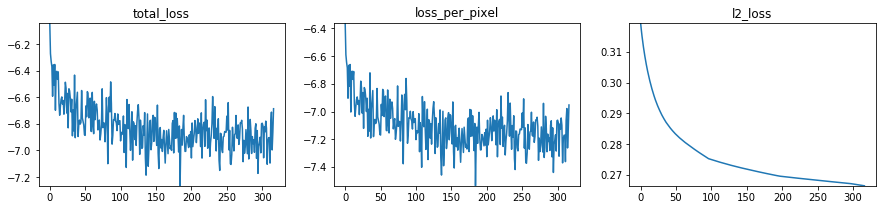

100%|██████████| 1000/1000 [04:13<00:00,  3.94it/s]


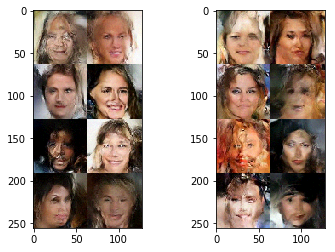

  5%|▌         | 50/1000 [00:12<03:50,  4.12it/s]

total_loss -6.820382
loss_per_pixel -7.0868106
l2_loss 0.26642832


 10%|█         | 100/1000 [00:24<03:44,  4.01it/s]

total_loss -6.926432
loss_per_pixel -7.1928234
l2_loss 0.2663915


 15%|█▌        | 150/1000 [00:37<03:33,  3.97it/s]

total_loss -6.73954
loss_per_pixel -7.0058937
l2_loss 0.26635364


 20%|██        | 200/1000 [00:50<03:22,  3.96it/s]

total_loss -7.2541986
loss_per_pixel -7.5205145
l2_loss 0.2663161


 25%|██▌       | 250/1000 [01:02<03:08,  3.97it/s]

total_loss -6.823866
loss_per_pixel -7.090144
l2_loss 0.26627827


 30%|███       | 300/1000 [01:15<02:56,  3.97it/s]

total_loss -6.776396
loss_per_pixel -7.042639
l2_loss 0.2662428


 35%|███▌      | 350/1000 [01:28<02:43,  3.98it/s]

total_loss -6.994388
loss_per_pixel -7.2605925
l2_loss 0.26620433


 40%|████      | 400/1000 [01:40<02:30,  3.98it/s]

total_loss -7.0522614
loss_per_pixel -7.318429
l2_loss 0.26616746


 45%|████▌     | 450/1000 [01:53<02:18,  3.97it/s]

total_loss -7.065425
loss_per_pixel -7.3315554
l2_loss 0.2661304


 50%|█████     | 500/1000 [02:05<02:05,  3.98it/s]

total_loss -6.6932282
loss_per_pixel -6.959322
l2_loss 0.26609355


 55%|█████▌    | 550/1000 [02:18<01:53,  3.98it/s]

total_loss -6.963395
loss_per_pixel -7.229451
l2_loss 0.2660562


 60%|██████    | 600/1000 [02:30<01:40,  3.98it/s]

total_loss -7.066115
loss_per_pixel -7.3321314
l2_loss 0.26601648


 65%|██████▌   | 650/1000 [02:43<01:27,  3.98it/s]

total_loss -6.787519
loss_per_pixel -7.0534973
l2_loss 0.26597843


 70%|███████   | 700/1000 [02:55<01:15,  3.98it/s]

total_loss -6.9500823
loss_per_pixel -7.2160234
l2_loss 0.26594096


 75%|███████▌  | 750/1000 [03:08<01:02,  3.98it/s]

total_loss -6.884187
loss_per_pixel -7.150091
l2_loss 0.26590407


 80%|████████  | 800/1000 [03:21<00:50,  3.98it/s]

total_loss -6.8586025
loss_per_pixel -7.124469
l2_loss 0.26586637


 85%|████████▌ | 850/1000 [03:34<00:37,  3.96it/s]

total_loss -6.992665
loss_per_pixel -7.258496
l2_loss 0.2658311


 90%|█████████ | 900/1000 [03:47<00:25,  3.96it/s]

total_loss -6.960349
loss_per_pixel -7.2261424
l2_loss 0.2657935


 95%|█████████▌| 950/1000 [04:00<00:12,  3.96it/s]

total_loss -6.699738
loss_per_pixel -6.9654956
l2_loss 0.26575744


100%|█████████▉| 999/1000 [04:12<00:00,  3.95it/s]

total_loss -6.874496
loss_per_pixel -7.140214
l2_loss 0.2657179


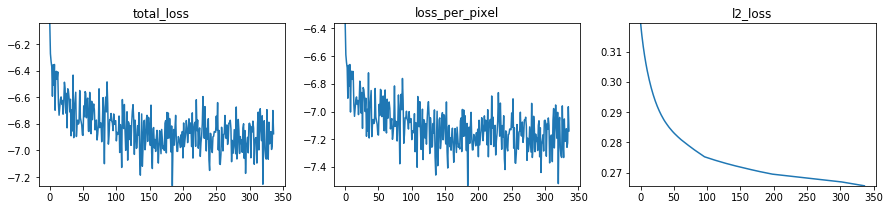

100%|██████████| 1000/1000 [04:13<00:00,  3.95it/s]


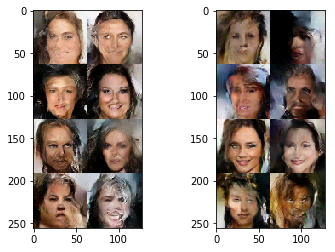

  5%|▌         | 50/1000 [00:12<03:57,  3.99it/s]

total_loss -6.8320475
loss_per_pixel -7.0977306
l2_loss 0.26568305


 10%|█         | 100/1000 [00:25<03:45,  3.98it/s]

total_loss -6.914337
loss_per_pixel -7.179983
l2_loss 0.26564616


 15%|█▌        | 150/1000 [00:37<03:34,  3.96it/s]

total_loss -6.680648
loss_per_pixel -6.9462576
l2_loss 0.26560977


 20%|██        | 200/1000 [00:50<03:22,  3.96it/s]

total_loss -6.5709343
loss_per_pixel -6.8365088
l2_loss 0.2655744


 25%|██▌       | 250/1000 [01:03<03:11,  3.92it/s]

total_loss -6.828949
loss_per_pixel -7.0944853
l2_loss 0.26553625


 30%|███       | 300/1000 [01:17<02:59,  3.90it/s]

total_loss -6.8243256
loss_per_pixel -7.0898237
l2_loss 0.2654982


 35%|███▌      | 350/1000 [01:29<02:45,  3.92it/s]

total_loss -6.9575667
loss_per_pixel -7.223029
l2_loss 0.26546222


 40%|████      | 400/1000 [01:41<02:32,  3.94it/s]

total_loss -6.689522
loss_per_pixel -6.9549484
l2_loss 0.26542655


 45%|████▌     | 450/1000 [01:54<02:19,  3.95it/s]

total_loss -6.994112
loss_per_pixel -7.2595015
l2_loss 0.2653895


 50%|█████     | 500/1000 [02:06<02:06,  3.94it/s]

total_loss -7.0255346
loss_per_pixel -7.290886
l2_loss 0.26535153


 55%|█████▌    | 550/1000 [02:19<01:54,  3.93it/s]

total_loss -6.7695756
loss_per_pixel -7.034889
l2_loss 0.2653137


 60%|██████    | 600/1000 [02:32<01:41,  3.93it/s]

total_loss -6.6944437
loss_per_pixel -6.959721
l2_loss 0.2652772


 65%|██████▌   | 650/1000 [02:45<01:29,  3.93it/s]

total_loss -6.918504
loss_per_pixel -7.1837444
l2_loss 0.2652401


 70%|███████   | 700/1000 [02:58<01:16,  3.93it/s]

total_loss -6.7191753
loss_per_pixel -6.984377
l2_loss 0.2652014


 75%|███████▌  | 750/1000 [03:10<01:03,  3.93it/s]

total_loss -6.9642305
loss_per_pixel -7.229395
l2_loss 0.26516455


 80%|████████  | 800/1000 [03:24<00:51,  3.92it/s]

total_loss -7.0792437
loss_per_pixel -7.3443704
l2_loss 0.26512688


 85%|████████▌ | 850/1000 [03:37<00:38,  3.90it/s]

total_loss -6.9189167
loss_per_pixel -7.184006
l2_loss 0.26508945


 90%|█████████ | 900/1000 [03:50<00:25,  3.90it/s]

total_loss -6.836055
loss_per_pixel -7.1011105
l2_loss 0.26505557


 95%|█████████▌| 950/1000 [04:03<00:12,  3.90it/s]

total_loss -6.7201
loss_per_pixel -6.9851193
l2_loss 0.2650192


100%|█████████▉| 999/1000 [04:16<00:00,  3.89it/s]

total_loss -6.9770613
loss_per_pixel -7.2420444
l2_loss 0.26498336


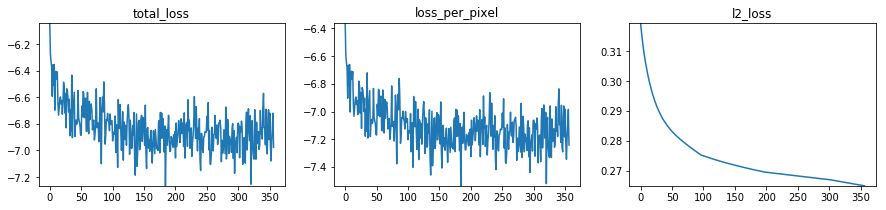

100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s]


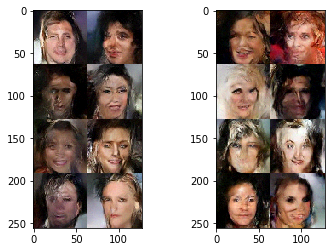

  5%|▌         | 50/1000 [00:12<03:57,  4.00it/s]

total_loss -6.9882193
loss_per_pixel -7.2531643
l2_loss 0.26494515


 10%|█         | 100/1000 [00:25<03:47,  3.96it/s]

total_loss -7.157979
loss_per_pixel -7.4228854
l2_loss 0.26490617


 15%|█▌        | 150/1000 [00:38<03:35,  3.95it/s]

total_loss -6.9659686
loss_per_pixel -7.230838
l2_loss 0.2648693


 20%|██        | 200/1000 [00:50<03:23,  3.94it/s]

total_loss -6.699691
loss_per_pixel -6.9645224
l2_loss 0.26483163


 25%|██▌       | 250/1000 [01:02<03:08,  3.97it/s]

total_loss -6.973953
loss_per_pixel -7.2387495
l2_loss 0.26479673


 30%|███       | 300/1000 [01:15<02:56,  3.97it/s]

total_loss -6.8830423
loss_per_pixel -7.1478004
l2_loss 0.26475793


 35%|███▌      | 350/1000 [01:28<02:44,  3.95it/s]

total_loss -7.0389814
loss_per_pixel -7.303705
l2_loss 0.26472375


 40%|████      | 400/1000 [01:40<02:31,  3.96it/s]

total_loss -6.9414206
loss_per_pixel -7.206104
l2_loss 0.2646832


 45%|████▌     | 450/1000 [01:53<02:18,  3.96it/s]

total_loss -6.950938
loss_per_pixel -7.215584
l2_loss 0.2646455


 50%|█████     | 500/1000 [02:06<02:06,  3.97it/s]

total_loss -7.0499063
loss_per_pixel -7.314516
l2_loss 0.26460996


 55%|█████▌    | 550/1000 [02:18<01:53,  3.98it/s]

total_loss -6.9428144
loss_per_pixel -7.207386
l2_loss 0.26457182


 60%|██████    | 600/1000 [02:31<01:40,  3.97it/s]

total_loss -6.9096665
loss_per_pixel -7.1742034
l2_loss 0.26453674


 65%|██████▌   | 650/1000 [02:43<01:28,  3.97it/s]

total_loss -6.8595223
loss_per_pixel -7.1240206
l2_loss 0.26449838


 70%|███████   | 700/1000 [02:56<01:15,  3.97it/s]

total_loss -6.7681227
loss_per_pixel -7.032584
l2_loss 0.26446155


 75%|███████▌  | 750/1000 [03:09<01:03,  3.96it/s]

total_loss -6.7987185
loss_per_pixel -7.0631447
l2_loss 0.2644263


 80%|████████  | 800/1000 [03:22<00:50,  3.95it/s]

total_loss -6.9284325
loss_per_pixel -7.192823
l2_loss 0.2643907


 85%|████████▌ | 850/1000 [03:35<00:37,  3.95it/s]

total_loss -7.097652
loss_per_pixel -7.3620057
l2_loss 0.26435396


 90%|█████████ | 900/1000 [03:48<00:25,  3.94it/s]

total_loss -6.960528
loss_per_pixel -7.224846
l2_loss 0.2643178


 95%|█████████▌| 950/1000 [04:01<00:12,  3.94it/s]

total_loss -6.9649563
loss_per_pixel -7.2292376
l2_loss 0.2642814


100%|█████████▉| 999/1000 [04:14<00:00,  3.93it/s]

total_loss -6.8162527
loss_per_pixel -7.0804996
l2_loss 0.26424697


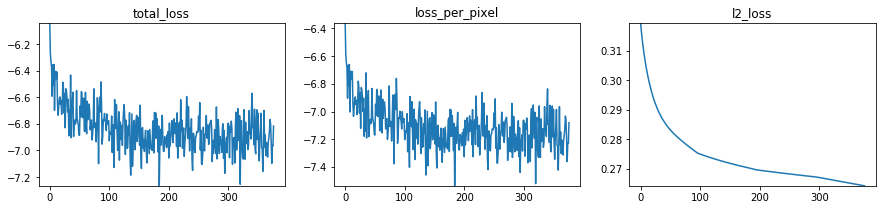

100%|██████████| 1000/1000 [04:14<00:00,  3.92it/s]


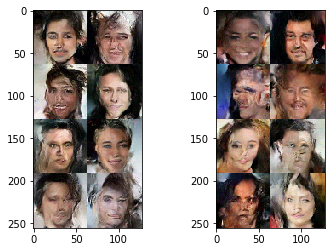

  5%|▌         | 50/1000 [00:12<03:58,  3.98it/s]

total_loss -7.000177
loss_per_pixel -7.264385
l2_loss 0.2642083


 10%|█         | 100/1000 [00:25<03:46,  3.97it/s]

total_loss -6.7848783
loss_per_pixel -7.0490484
l2_loss 0.26417014


 15%|█▌        | 150/1000 [00:37<03:34,  3.96it/s]

total_loss -6.905883
loss_per_pixel -7.1700163
l2_loss 0.2641336


 20%|██        | 200/1000 [00:50<03:21,  3.97it/s]

total_loss -6.980641
loss_per_pixel -7.2447395
l2_loss 0.26409853


 25%|██▌       | 250/1000 [01:02<03:08,  3.98it/s]

total_loss -6.8693876
loss_per_pixel -7.1334496
l2_loss 0.26406196


 30%|███       | 300/1000 [01:15<02:56,  3.97it/s]

total_loss -6.789055
loss_per_pixel -7.05308
l2_loss 0.26402497


 35%|███▌      | 350/1000 [01:28<02:43,  3.98it/s]

total_loss -6.8513775
loss_per_pixel -7.1153684
l2_loss 0.26399082


 40%|████      | 400/1000 [01:40<02:31,  3.96it/s]

total_loss -6.947022
loss_per_pixel -7.2109776
l2_loss 0.2639557


 45%|████▌     | 450/1000 [01:53<02:18,  3.96it/s]

total_loss -7.1697607
loss_per_pixel -7.43368
l2_loss 0.26391914


 50%|█████     | 500/1000 [02:06<02:06,  3.94it/s]

total_loss -6.976994
loss_per_pixel -7.240877
l2_loss 0.26388308


 55%|█████▌    | 550/1000 [02:19<01:53,  3.95it/s]

total_loss -6.8846173
loss_per_pixel -7.148464
l2_loss 0.2638467


 60%|██████    | 600/1000 [02:31<01:41,  3.95it/s]

total_loss -6.9272094
loss_per_pixel -7.19102
l2_loss 0.26381052


 65%|██████▌   | 650/1000 [02:44<01:28,  3.96it/s]

total_loss -6.920381
loss_per_pixel -7.1841564
l2_loss 0.26377535


 70%|███████   | 700/1000 [02:57<01:15,  3.95it/s]

total_loss -6.683607
loss_per_pixel -6.9473457
l2_loss 0.2637387


 75%|███████▌  | 750/1000 [03:10<01:03,  3.94it/s]

total_loss -7.0129795
loss_per_pixel -7.2766843
l2_loss 0.26370454


 80%|████████  | 800/1000 [03:23<00:50,  3.93it/s]

total_loss -6.850345
loss_per_pixel -7.114015
l2_loss 0.26366985


 85%|████████▌ | 850/1000 [03:36<00:38,  3.92it/s]

total_loss -6.890962
loss_per_pixel -7.1545963
l2_loss 0.26363403


 90%|█████████ | 900/1000 [03:49<00:25,  3.93it/s]

total_loss -6.7750487
loss_per_pixel -7.0386457
l2_loss 0.2635972


 95%|█████████▌| 950/1000 [04:02<00:12,  3.92it/s]

total_loss -6.894675
loss_per_pixel -7.1582355
l2_loss 0.2635606


100%|█████████▉| 999/1000 [04:14<00:00,  3.92it/s]

total_loss -7.0354633
loss_per_pixel -7.298986
l2_loss 0.26352283


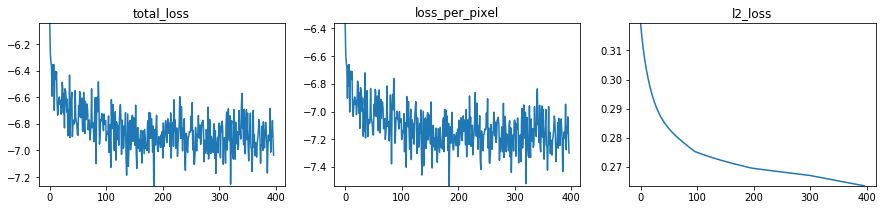

100%|██████████| 1000/1000 [04:15<00:00,  3.92it/s]


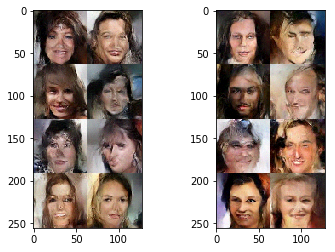

In [37]:
for i in range(5):
    utils.trainer(
        sess, 
        num_steps=1000, 
        train_op=train_op, 
        feed_dict_fn=lambda: {lr_ph: 0.0001, beta_ph: 1.0}, 
        metrics=[metrics], 
        hooks=[plot_metrics_hook]
    )
    
    plt.subplot(121)
    plt.imshow(utils.plot_grid(x_flow_sampled_uint).eval({lr_ph: 0.0, beta_ph: 0.9}))
    plt.subplot(122)
    plt.imshow(utils.plot_grid(x_flow_sampled_uint).eval({lr_ph: 0.0, beta_ph: 1.0}))
    plt.show()

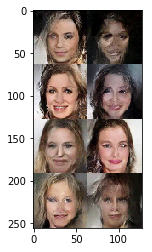

In [39]:
plt.imshow(utils.plot_grid(x_flow_sampled_uint).eval({lr_ph: 0.0, beta_ph: 0.8}))

## Generate samples for different temperatures

We start from zero T i.e. the input standard deviation is zero. We can see simialar 
conclusion as in paper, sampling from reduced temperature yield in better results.

beta=    0.0000


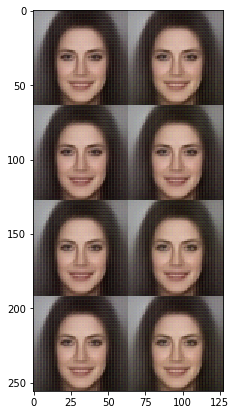

beta=    0.1667


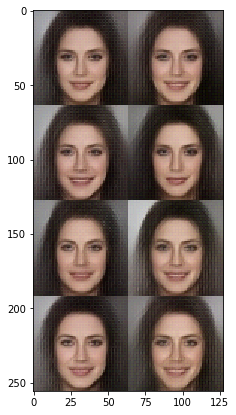

beta=    0.3333


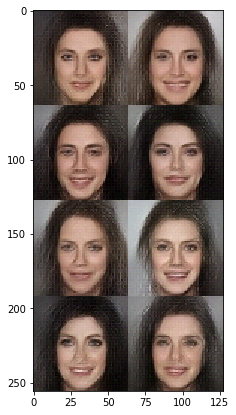

beta=    0.5000


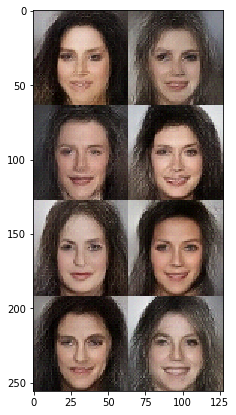

beta=    0.6667


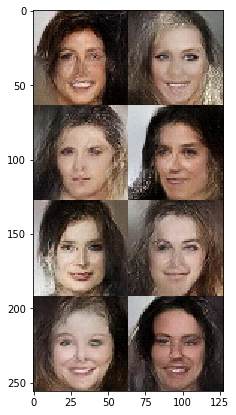

beta=    0.8333


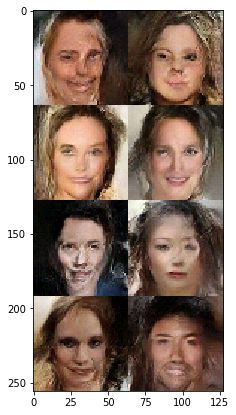

beta=    1.0000


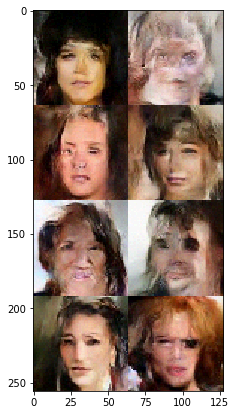

beta=    1.1667


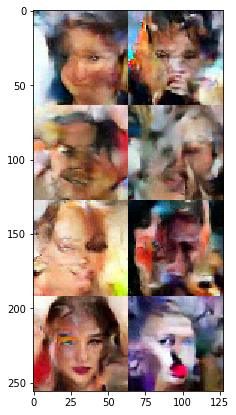

beta=    1.3333


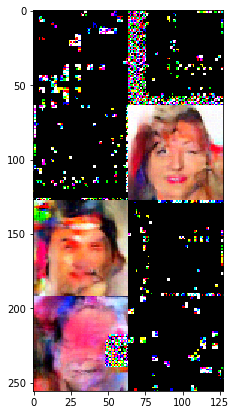

beta=    1.5000


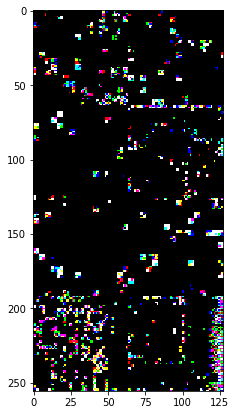

In [41]:
for beta in np.linspace(0.0, 1.5, 10):
    print(f"beta={beta:10.4f}")
    plt.figure(figsize=(7, 7))
    plt.imshow(utils.plot_grid(x_flow_sampled_uint).eval({lr_ph: 0.0, beta_ph: beta}))
    plt.show()

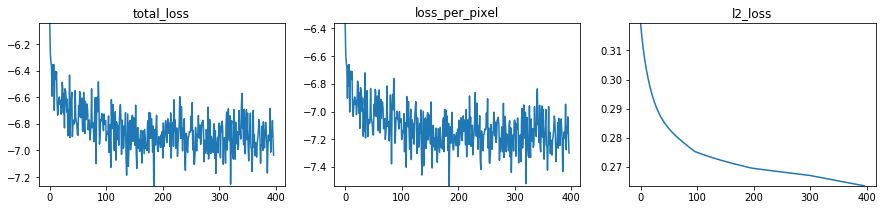

In [42]:
plot_metrics_hook.run()

## Investigate latent space statistics
Check whether the distribution of the latent variables fits the prior distribution. We should observe gaussian

In [43]:
y_flatten_np = np.concatenate([y_flatten.eval({lr_ph: 0.0, beta_ph: 1.0}) for i in range(100)])
y_flatten_np.shape

(800, 768)

### 2D scatter plot for 0-th and 1-st latent variable

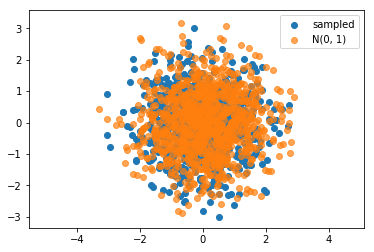

In [44]:
plt.scatter(y_flatten_np[:, 0], y_flatten_np[:, 1], label="sampled")
plt.scatter(*np.random.randn(2, 1000), alpha=0.7, label="N(0, 1)")
plt.axis("equal")
plt.legend()

### Histogram of all activations of Y latent variable

(-4, 4)

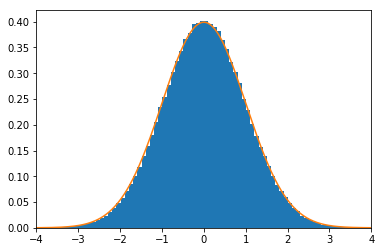

In [45]:
_ = plt.hist(y_flatten_np.reshape([-1]), 100, normed=True)
x_axis = np.arange(-4, 4, 0.01)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1))
plt.xlim([-4, 4])

### Histogram of all activations of Z latent variable

(-4, 4)

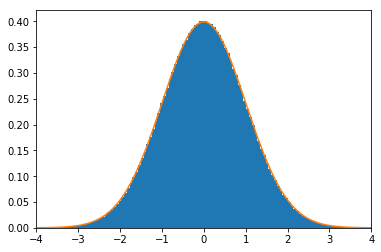

In [60]:
z_flatten_np = np.concatenate([z_flatten.eval({lr_ph: 0.0, beta_ph: 1.0}) for i in range(100)])
_ = plt.hist(z_flatten_np.reshape([-1]), 200, normed=True)
x_axis = np.arange(-4, 4, 0.01)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1))
plt.xlim([-4, 4])

## Tuning temperature separatelly for Y and Z latent variables

This seems to generate the best results when the temperature of the distribution of the Z variable is close 
or equal zero. 

In [46]:
beta_y_ph = tf.placeholder(tf.float32, [])
beta_z_ph = tf.placeholder(tf.float32, [])
prior_y_prim = tfd.MultivariateNormalDiag(
    loc=tf.zeros_like(y_flatten), scale_diag=beta_y_ph * tf.ones_like(y_flatten))
prior_z_prim = tfd.MultivariateNormalDiag(
    loc=tf.zeros_like(z_flatten), scale_diag=beta_z_ph * tf.ones_like(z_flatten))

In [47]:
sample_y_flatten_prim = prior_y_prim.sample()
sample_y_prim = tf.reshape(sample_y_flatten_prim, y.shape.as_list())
sample_z_prim = tf.reshape(prior_z_prim.sample(), z.shape.as_list())
sampled_logdet_prim = prior_y_prim.log_prob(sample_y_flatten_prim)

In [48]:
inverse_flow_prim = sample_y_prim, sampled_logdet_prim, sample_z_prim
sampled_flow_prim = model_flow(inverse_flow_prim, forward=False)

FactorOutLayer/Backward/Scale4          : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
AffineCouplingLayer/Backward/           : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
InvertibleConv1x1Layer/Backward/        : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
ActnormScaleLayer/Backward/             : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
ActnormBiasLayer/Backward/              : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
ChainLayer/Backward/                    : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
ActnormLayer/Backward/                  : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
ChainLayer/Backward/Step22              : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
AffineCouplingLayer/Backward/           : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
InvertibleConv1x1Layer/Backward/        : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
ActnormScaleLayer/Backward/             : y=[8, 4, 4, 96]	z=[8, 4, 4, 672]	logdet=[8]
ActnormBiasLayer/Backward/              : y=[8, 4, 4, 

In [49]:
x_flow_sampled_prim, _, _ = sampled_flow_prim

### Efect of the temperature on the Z latent variable

beta=    0.0000


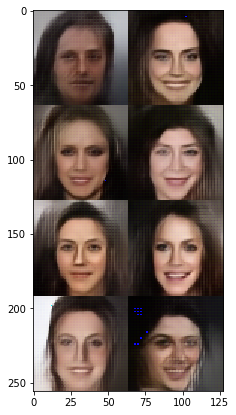

beta=    0.1111


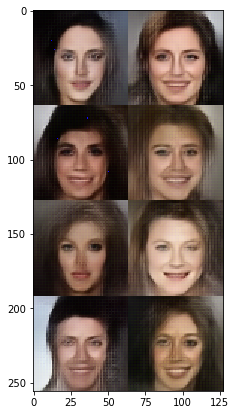

beta=    0.2222


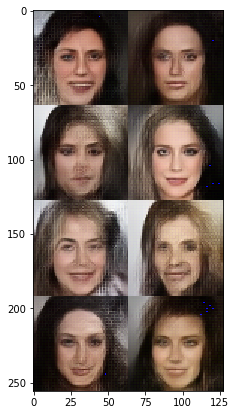

beta=    0.3333


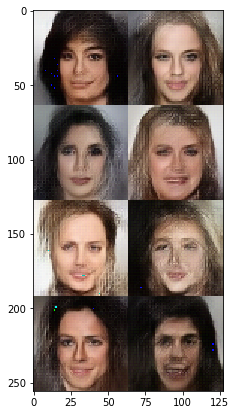

beta=    0.4444


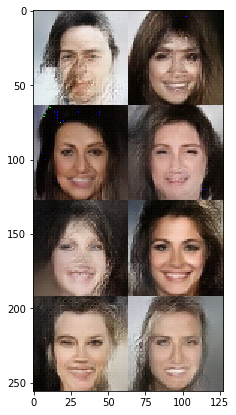

beta=    0.5556


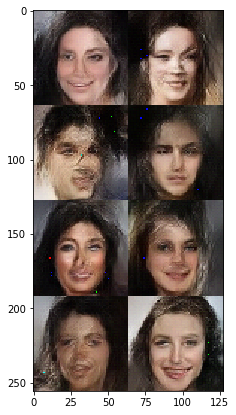

beta=    0.6667


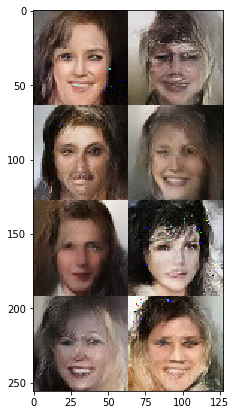

beta=    0.7778


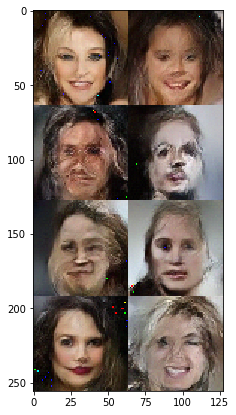

beta=    0.8889


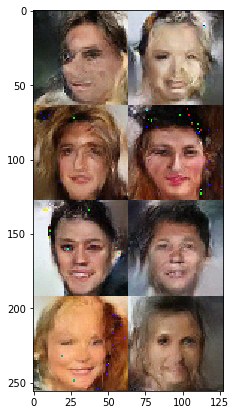

beta=    1.0000


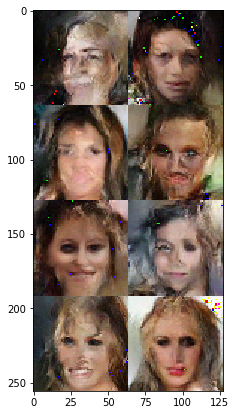

In [51]:
for beta in np.linspace(0.0, 1.0, 10):
    print(f"beta={beta:10.4f}")
    plt.figure(figsize=(7, 7))
    plt.imshow(utils.plot_grid(x_flow_sampled_prim).eval({
        lr_ph: 0.0,
        beta_y_ph: 0.9, 
        beta_z_ph: beta
    }))
    plt.show()

### Efect of the temperature on the Y latent variable when beta_z=0.1

beta=    0.0000


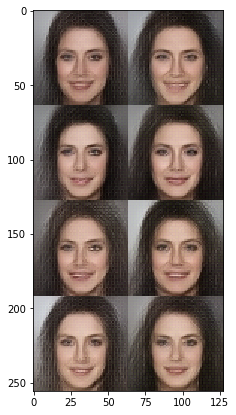

beta=    0.1111


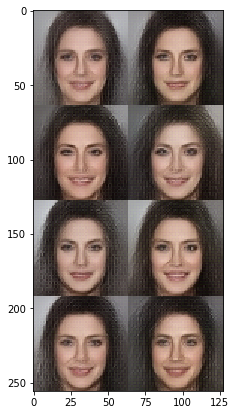

beta=    0.2222


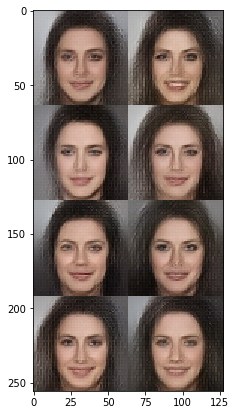

beta=    0.3333


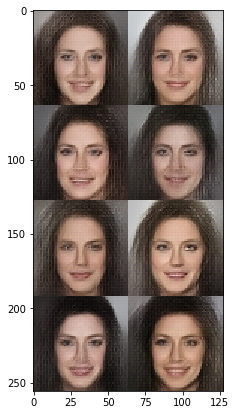

beta=    0.4444


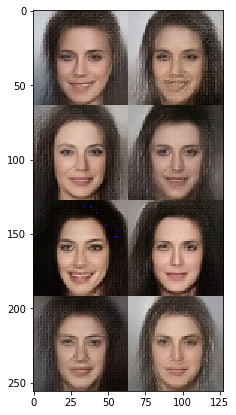

beta=    0.5556


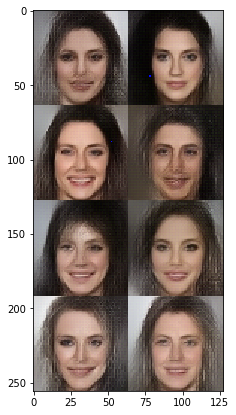

beta=    0.6667


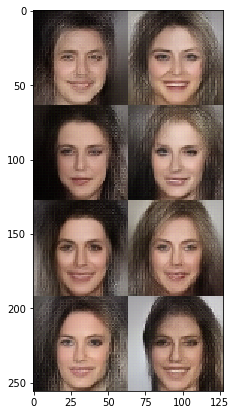

beta=    0.7778


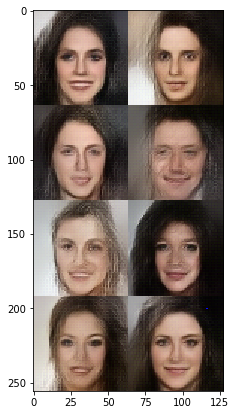

beta=    0.8889


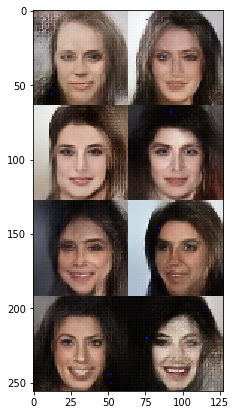

beta=    1.0000


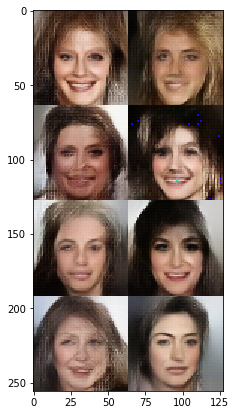

In [52]:
for beta in np.linspace(0.0, 1.0, 10):
    print(f"beta={beta:10.4f}")
    plt.figure(figsize=(7, 7))
    plt.imshow(utils.plot_grid(x_flow_sampled_prim).eval({
        lr_ph: 0.0,
        beta_y_ph: beta, 
        beta_z_ph: 0.3
    }))
    plt.show()

# Save model

In [53]:
saver = tf.train.Saver()
save_path = saver.save(sess, "./experiments/celeba64x64_22steps.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: ./experiments/celeba64x64_22steps.ckpt
